# Random Corona Walk

MOD510 Mandatory project #4
Deadline: 12 December 2021 (23:59)

## Abstract

In this project SI, SIR and SVIR compartment models are used in conjunction with a 2D random walk algorithm to model the first wave of the outbreak and spread of COVID-19. 

At first a random walk algorithm is implemented in conjunction with a simple SI-model, which is later expanded to the SIR-model and SVIR-model to include recovered and vaccinated people respectively. 

The means and standard deviations are calculated for each step across 100 runs to estimate beta and tau_sick values, which are used to compare the random walk simulations with the analytical solution to the SI-model and a deterministic SIR model.

The effects of changing the values for intially infected people, infection probability and recoveryrate are examined.

Different policies for vaccine introductions are simulated using the SVIR model to examin their effect on the outbreak development. They confirm that a fast deployment of the vaccine as soon as it is available greatly reduces the mumber of people getting infected.

## Introduction

As of writing this report there have been almost 268 million confirmed COVID-19 cases worldwide, causing over 5.28 million reported deaths. [1]

The actual number of deaths, including unreported deaths, are estimated to be more than twice as high at about 12.39 million deaths. [2]

This makes the COVID-19 pandemic the 3rd largest pandemic in terms of total deaths since 1900 after the Spanish Flu at about 45 million deaths and HIV/AIDS at about 35 million deaths. [2][3][4]

The outbreak and spread of the Corona Virus can be modeled by using a 2D random walk algorithm in conjunction with compartment models.



### Theory

Compartment models describe the flow of people from one compartment to another. In case of the simulation of infectious diseases such as the covid19 pandemic the simplest form of a compartment model is the SI-model where people flow from the Susceptible (S) compartment to the Infected (I) compartment.

In a random walk simulation people randomly walk around on a grid. To avoid people from walking outside the grid a bounce back boundary is introduced, bouncing them back to their previous position in case they try to walk outside of the boundaries. 

In case of our covid19 simulation each "Walker" has an infection status. For the SI-model this status is either S or I. When a walker with the status S meets a walker with the status I, his status may be changed from S to I, according to an infection probability q. 

By repeating this algorithm (running a simulation) and using scatterplots depicting the X and Y coordinates of the walkers as well as their status (using different colors), and lineplots displaying the total number of walkers for each status over time the spread and development of the outbreak can be visualized.

Because random walk simulations are based on random movement the result will slightly differ each time the simulation is run. Therefore it has to be run multiple times to be able to calculate the mean and standard deviation across all runs for each timestep to display a smooth average result including uncertainties.

To speed-up running the codes, we used the multuprocessing package in python. multiprocessing allows you to start processes using a threading-like API. By employing subprocesses instead of threads, the multiprocessing package provides both local and remote concurrency. This module allows the programmer to utilize all cpus on a single computer. One of the best features of this package is Pool, which allows you to parallelize the execution of a function over several input values while also dispersing the data across processes.


## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
import scipy as sp
import scipy.integrate
import multiprocessing as mp 
from multiprocessing import Process 
import numpy as np 
from timeit import default_timer as timer

## Class definition

Almost all functions created during the completion of this assignment are inside this class:

In [2]:
class RandomWalkEpidemicSimulator:
    """
    Class used to model the spreading of a contagious disease in a
    population of individuals with a 2D random walk.

    Each walker has a disease status and a set of integer (x, y)-coordinates that are
    stored and updated for each walker in a dataframe. 
    
    The possible coordinates are:

        {0, 1, ..., Lx-1} in the x-direction
        {0, 1, ..., Ly-1} in the y-direction

    The disease statuses are:

        S: Susceptible
        V: Vaccinated
        I: Infected
        R: Recovered

    It is only possible to move North, South, East, or West. If a
    walker attempts to move outside of the physical domain, nothing
    happens (i.e., a "bounce-back boundary condition" is enforced).
    """
    def __init__(self,
                 population_size,
                 no_init_infected=1,
                 nx=50,
                 ny=50,
                 q=0.9,
                 precover = 0):
        """
        :param population_size: The total number of people (N).
        :param no_init_infected: The number of infected people at t=0.
        :param nx: The number of lattice nodes in the x-direction
        :param ny: The number of lattice nodes in the y-direction.
        :param q: The probability of infection (0 <= q <= 1).
        """
        self.N = population_size
        self.I0 = no_init_infected
        self.nx = nx
        self.ny = ny
        self.infection_probability = q
        self.precover = precover

        # possible directions [N,S,E,W]
        self.directions = {'N':[0,1],
                           'S':[0,-1],
                           'E':[1,0],
                           'W':[-1,0]}
        self.Valid_X = np.arange(0,self.nx+1)
        self.Valid_Y = np.arange(0,self.ny+1)
        self.Valid_Pos = np.array([self.Valid_X,self.Valid_Y])

        self.Old_Pos=[]

        self.Walkers = pd.DataFrame(columns=['Status','X','Y'])
        
        self.f_Init_Pos()
        self.f_Init_Status()

    def f_Init_Status(self):
        self.Status = np.chararray(self.N,unicode=True)
        self.Status[:] = 'S'

        Infected = np.random.randint(0,self.N,self.I0)

        for i in range(self.I0):
            self.Status[Infected[i]] = 'I'
        self.Walkers['Status'] = self.Status

    def f_Init_Pos(self):
        self.Init_Pos = np.transpose((np.random.randint(low=[0,0],high=[self.nx,self.ny],size=(self.N,2))))
        self.Walkers['X'] = self.Init_Pos[0]
        self.Walkers['Y'] = self.Init_Pos[1]
        self.Old_Pos.append(self.Init_Pos)

    def f_Step(self):
        self.steps = np.random.choice(list(self.directions.keys()),size=self.N)
        self.steps = np.transpose(itemgetter(*self.steps)(self.directions))

    def f_Check_Invalid(self):
        for i in range(self.N):
            if self.New_Pos[0][i] not in self.Valid_Pos[0] or self.New_Pos[1][i] not in self.Valid_Pos[1]:
                self.New_Pos[0][i] = self.Old_Pos[-1][0][i]
                self.New_Pos[1][i] = self.Old_Pos[-1][1][i]

    def f_Check_Meet(self):
        Pos_I_X = self.Walkers['X'].loc[self.Walkers['Status']=='I']
        Pos_I_Y = self.Walkers['Y'].loc[self.Walkers['Status']=='I']

        Pos_S_X = self.Walkers['X'].loc[self.Walkers['Status']=='S']
        Pos_S_Y = self.Walkers['Y'].loc[self.Walkers['Status']=='S']

        IS_X = []
        IS_Y = []
        for i, x_i in Pos_I_X.iteritems():
          for s, x_s in Pos_S_X.iteritems():
            if x_i == x_s:
              if Pos_I_Y[i] == Pos_S_Y[s]:
                IS_X.append(x_i)
                IS_Y.append(Pos_I_Y[i])

        q = np.random.uniform(0, 1)
        if q < self.infection_probability:
            self.Walkers.loc[(self.Walkers.X.isin(IS_X))&(self.Walkers.Y.isin(IS_Y)),'Status'] = 'I'
            
    def f_Recover(self,precover):
        len_I = len(self.Walkers[self.Walkers.Status=='I'])
        I_indices = self.Walkers.index[self.Walkers.Status=='I'].values
        q_I = np.random.uniform(0, 1,len_I)
        R_indices = []
        for ind, i in enumerate(q_I):
            if i < precover:
                R_indices.append(I_indices[ind])
        self.Walkers.loc[(self.Walkers.index.isin(R_indices)),'Status'] = 'R'
                
    def f_Vaccinate(self,pvaccinate):
        len_S = len(self.Walkers[self.Walkers.Status=='S'])
        S_indices = self.Walkers.index[self.Walkers.Status=='S'].values
        q_S = np.random.uniform(0, 1,len_S)
        V_indices = []
        for ind, s in enumerate(q_S):
            if s < pvaccinate:
                V_indices.append(S_indices[ind])
        self.Walkers.loc[(self.Walkers.index.isin(V_indices)),'Status'] = 'V'
        
    def f_Walk(self,precover=0,pvaccinate=0):
        self.New_Pos = self.Old_Pos[-1]+self.steps
        self.f_Check_Invalid()
        self.Walkers['X'] = self.New_Pos[0]
        self.Walkers['Y'] = self.New_Pos[1]
        self.f_Check_Meet()
        self.Old_Pos.append(self.New_Pos)
        self.f_Recover(precover=self.precover)
        self.f_Vaccinate(pvaccinate)

    def plot(self,state):
        fig, ax = plt.subplots(figsize=(min(self.nx,12),min(self.ny,12)))
        plt.title(str('Step '+str(state+1)))
        colors = {'S':'tab:blue','R':'tab:orange','I':'greenyellow','V':'magenta'}
        for Status in self.Walkers['Status'].unique():
            ax.scatter(self.Walkers['X'].loc[self.Walkers['Status']==Status],
                        self.Walkers['Y'].loc[self.Walkers['Status']==Status],
                        label = Status,c=colors[Status])
        plt.xlim([-0.01*self.nx, self.nx+0.01*self.nx])
        plt.ylim([-0.01*self.nx, self.nx+0.01*self.nx])
        plt.legend(loc='upper right')
        plt.show

## Exercise 1

### Part 1

In [3]:
def COVID_RW_single_simulation_run(no_init_infected=1,population_size=683,nx=50,ny=50,steps = 300,report_every_n_steps = 30,precover=0,pvaccinate=0,crit_pop_percentage=20,q=0.9,report_infos=False,scatter_plots=True):
    C = RandomWalkEpidemicSimulator(no_init_infected=no_init_infected,population_size=population_size,nx=nx,ny=ny,q=q,precover=precover)

    S = []
    V = []
    I = []
    R = []

    for i in range(steps):
        C.f_Step()
        if len(C.Walkers.loc[C.Walkers['Status'] =='S']) > population_size*(1-(crit_pop_percentage/100)):
            C.f_Walk(precover=precover,pvaccinate=0)
        else:
            C.f_Walk(precover=precover,pvaccinate=pvaccinate)

        S.append(len(C.Walkers.loc[C.Walkers['Status'] =='S']))
        V.append(len(C.Walkers.loc[C.Walkers['Status'] =='V']))
        I.append(len(C.Walkers.loc[C.Walkers['Status'] =='I']))
        R.append(len(C.Walkers.loc[C.Walkers['Status'] =='R']))

        if i % report_every_n_steps == 0:
            if report_infos == True:
                print('Step',i)
                display(C.Walkers.head(10))
                print('\nS:',len(C.Walkers.loc[C.Walkers['Status'] =='S']),'\nV:',len(C.Walkers.loc[C.Walkers['Status'] =='V']),'\nI:',len(C.Walkers.loc[C.Walkers['Status'] =='I']),'\nR:',len(C.Walkers.loc[C.Walkers['Status'] =='R']))
            if scatter_plots == True:
                C.plot(i)
    
    return S,V,I,R


Step 0


,Status,X,Y
0,S,44,1
1,S,5,41
2,S,39,12
3,S,23,26
4,S,39,34
5,S,24,13
6,S,18,6
7,S,33,29
8,S,40,2
9,S,31,6



S: 682 
V: 0 
I: 1 
R: 0
Step 30


,Status,X,Y
0,S,39,0
1,S,4,48
2,S,43,8
3,S,22,21
4,S,43,40
5,S,25,20
6,S,23,5
7,S,35,31
8,S,35,5
9,S,33,6



S: 675 
V: 0 
I: 8 
R: 0
Step 60


,Status,X,Y
0,S,44,2
1,S,1,43
2,S,40,9
3,S,20,21
4,S,41,38
5,S,21,24
6,S,20,2
7,S,30,34
8,S,30,8
9,S,40,3



S: 645 
V: 0 
I: 38 
R: 0
Step 90


,Status,X,Y
0,S,50,2
1,I,1,43
2,S,45,16
3,S,28,19
4,S,40,41
5,S,13,16
6,S,19,7
7,I,33,35
8,S,28,10
9,S,38,2



S: 521 
V: 0 
I: 162 
R: 0
Step 120


,Status,X,Y
0,S,49,2
1,I,3,34
2,S,49,16
3,I,27,20
4,S,45,40
5,S,12,7
6,S,18,8
7,I,33,43
8,S,30,8
9,S,36,4



S: 298 
V: 0 
I: 385 
R: 0
Step 150


,Status,X,Y
0,I,47,9
1,I,0,37
2,S,48,25
3,I,34,21
4,I,44,35
5,I,9,16
6,S,16,0
7,I,22,46
8,S,28,6
9,I,40,10



S: 100 
V: 0 
I: 583 
R: 0
Step 180


,Status,X,Y
0,I,48,3
1,I,5,40
2,I,49,22
3,I,30,23
4,I,45,36
5,I,4,15
6,I,11,3
7,I,20,50
8,I,34,8
9,I,50,14



S: 4 
V: 0 
I: 679 
R: 0
Step 210


,Status,X,Y
0,I,47,8
1,I,2,42
2,I,50,23
3,I,28,19
4,I,48,35
5,I,4,15
6,I,9,0
7,I,24,47
8,I,37,3
9,I,44,23



S: 0 
V: 0 
I: 683 
R: 0
Step 240


,Status,X,Y
0,I,41,16
1,I,3,46
2,I,49,19
3,I,31,16
4,I,48,34
5,I,5,24
6,I,15,0
7,I,29,48
8,I,42,0
9,I,44,23



S: 0 
V: 0 
I: 683 
R: 0
Step 270


,Status,X,Y
0,I,34,13
1,I,5,44
2,I,50,15
3,I,38,19
4,I,48,40
5,I,0,27
6,I,19,2
7,I,22,49
8,I,35,1
9,I,48,20



S: 0 
V: 0 
I: 683 
R: 0


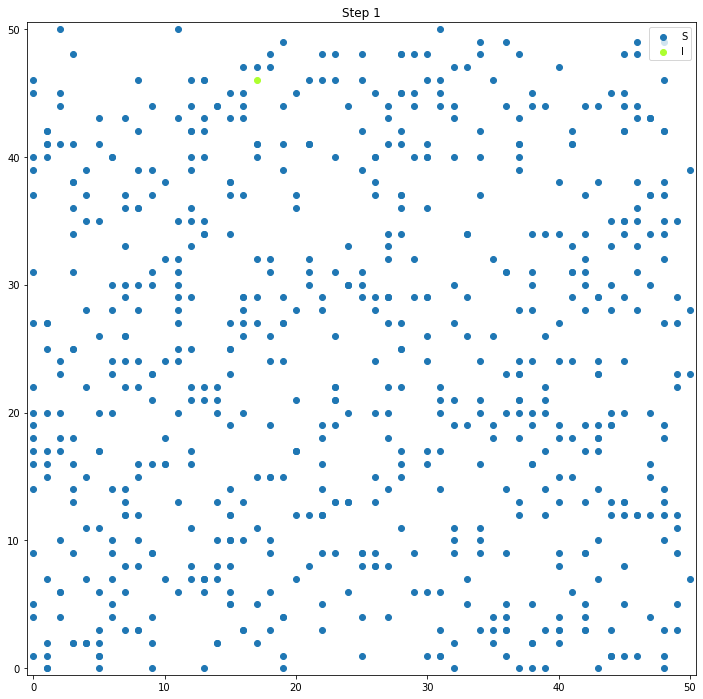

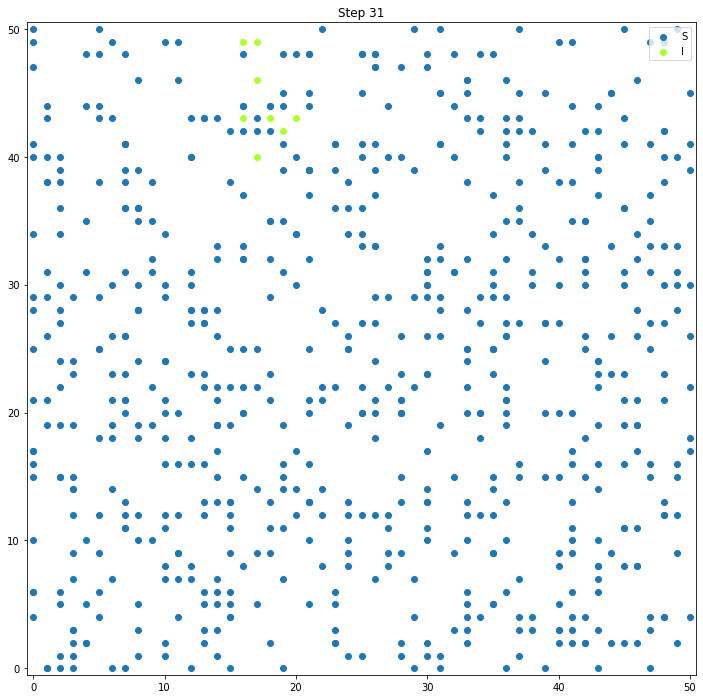

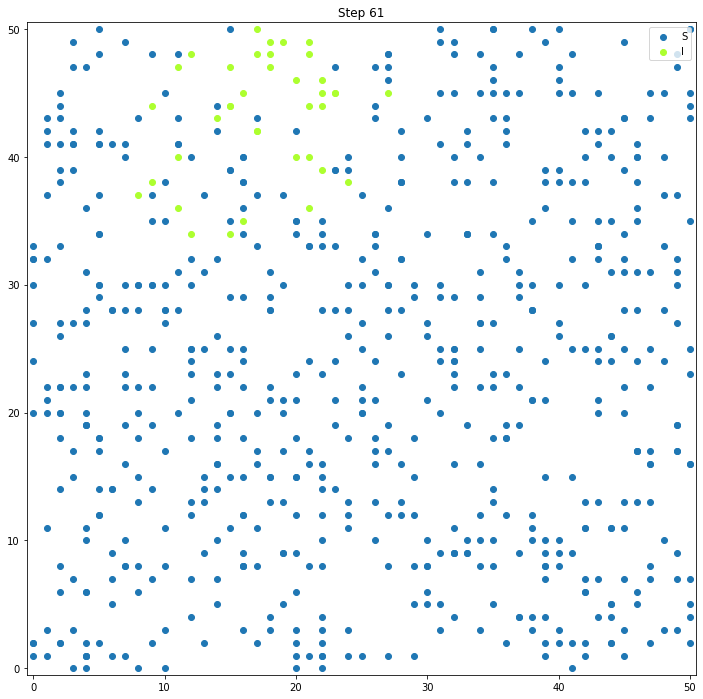

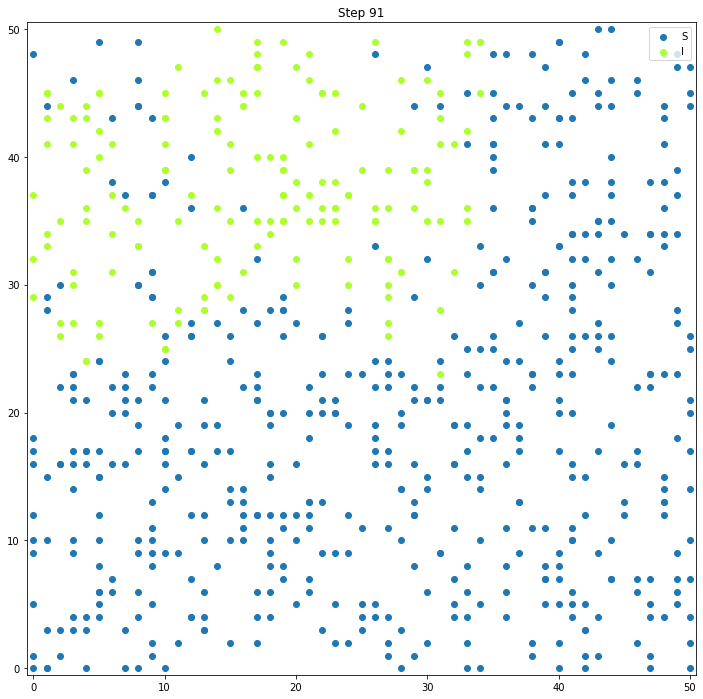

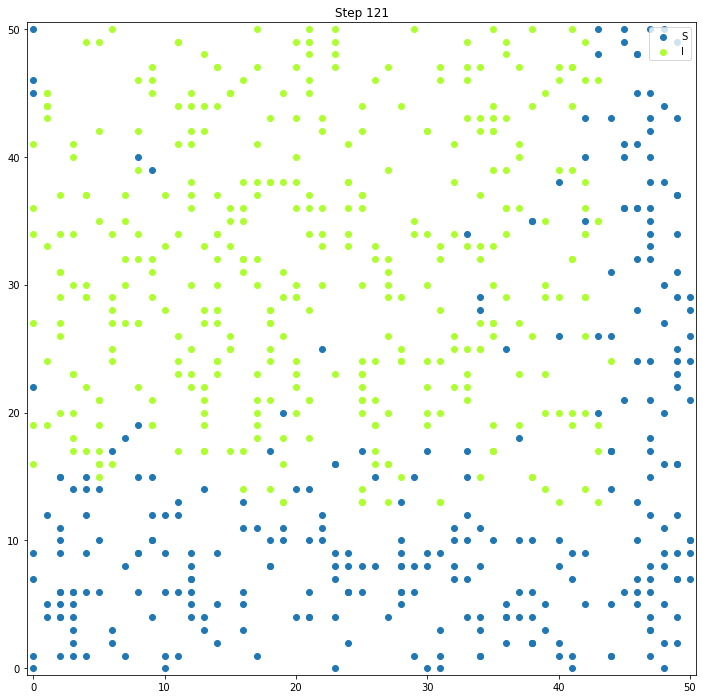

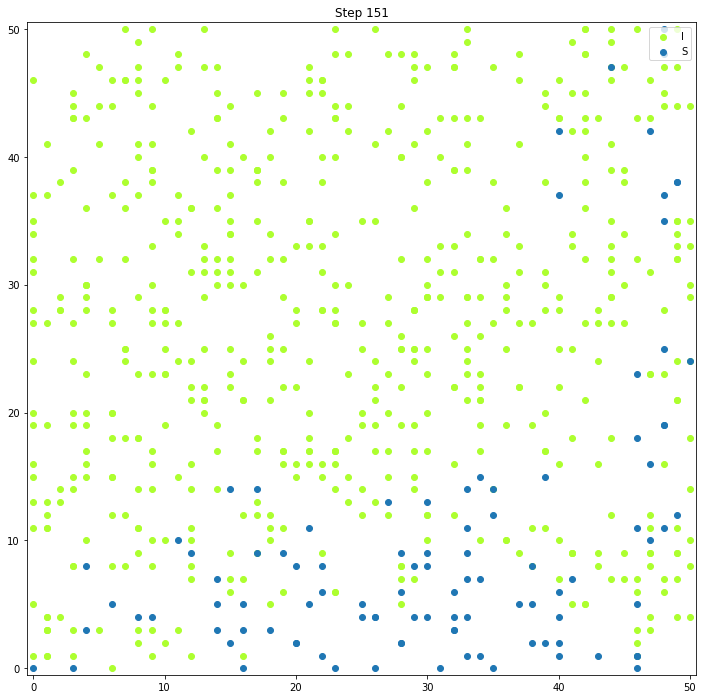

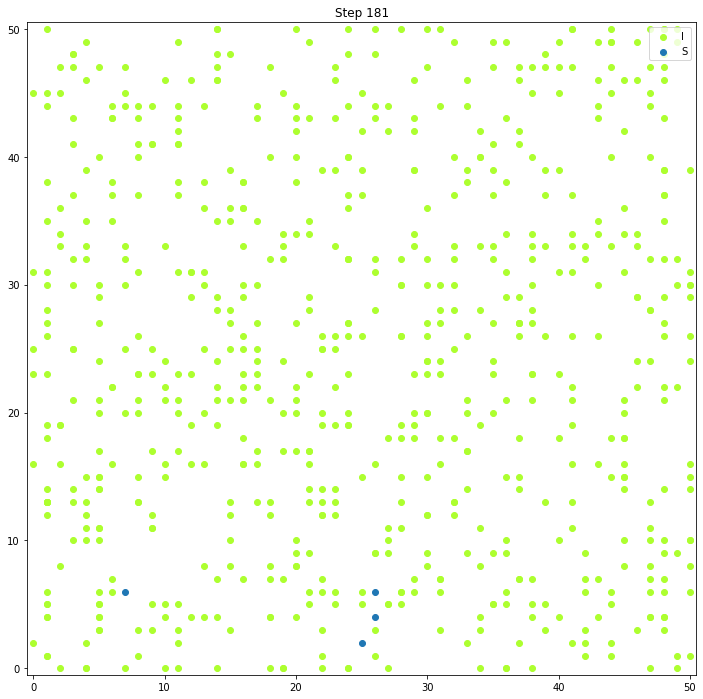

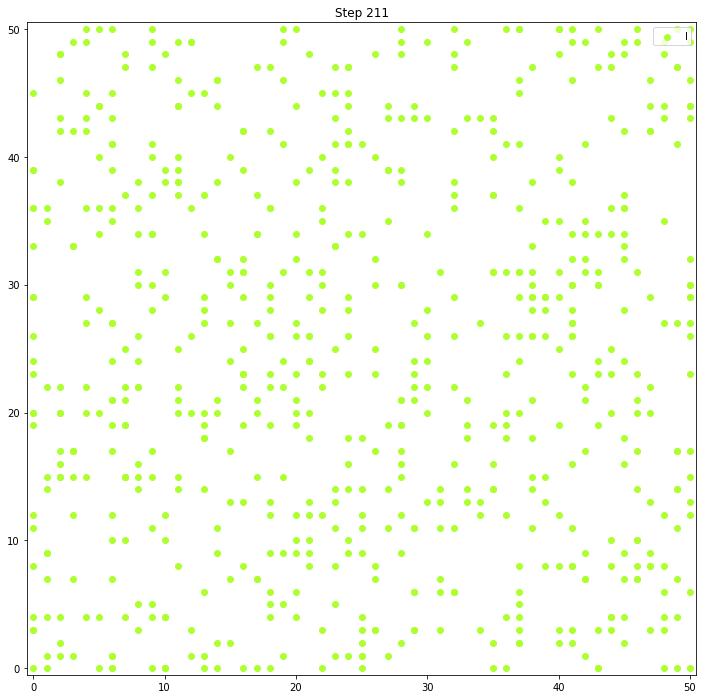

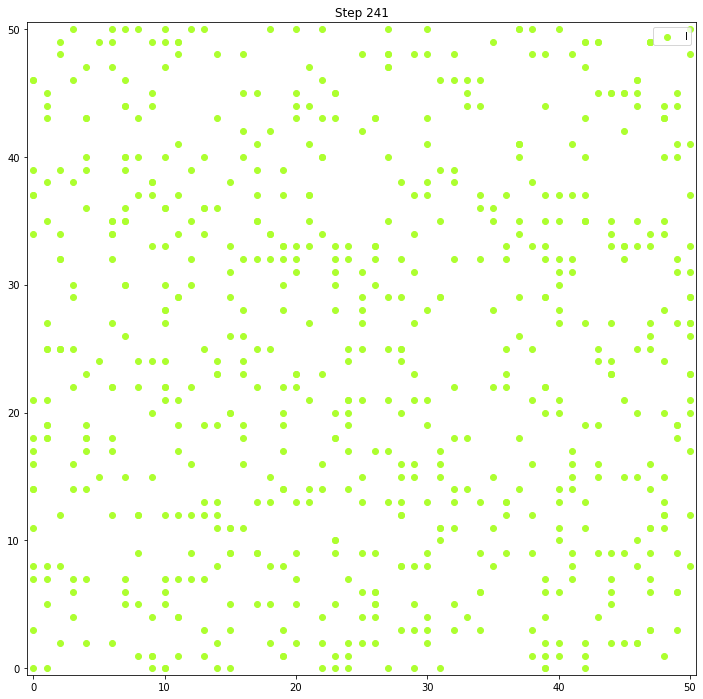

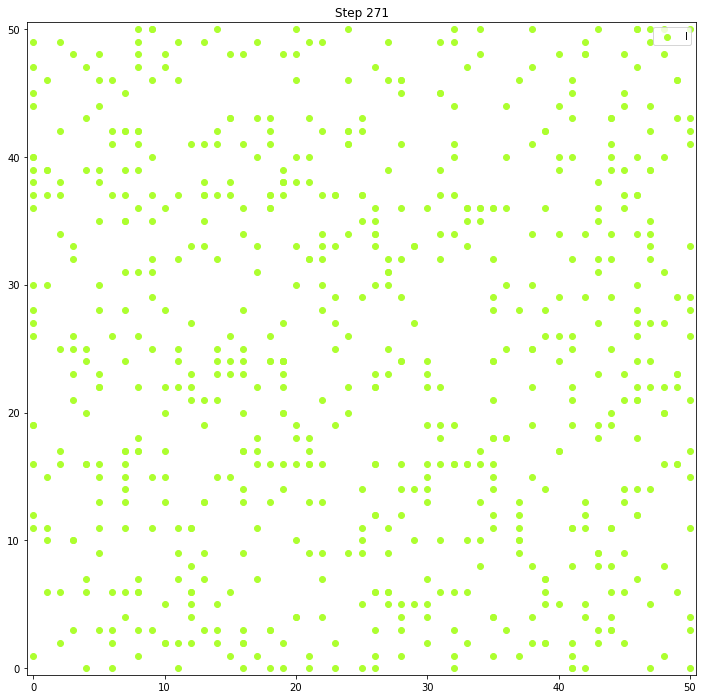

In [4]:

steps = 300
S,V,I,R = COVID_RW_single_simulation_run(no_init_infected=1,population_size=683,nx=50,ny=50,steps = steps,report_every_n_steps = 30,precover=0,pvaccinate=0,report_infos=True)


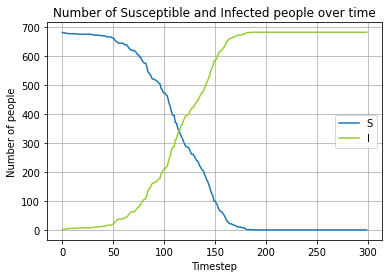

In [5]:
plt.plot(np.arange(0,steps,1),S,label = 'S', c='tab:blue')
plt.plot(np.arange(0,steps,1),I,label = 'I', c='yellowgreen')
plt.grid()
plt.title('Number of Susceptible and Infected people over time')
plt.xlabel('Timestep')
plt.ylabel('Number of people')
plt.legend()
plt.show()

### Part 2

The plots above show that the simulator is working as expected.

By looking at a the dataframe of each step for a smaller population of 10 people with 2 initial infected on a small 4x4 grid bellow, we can see, that the walkers never leave the grid, as the X and Y coordinates never exeed 4 or get below 0.

We can also see, that only those susceptible walkers that directly meet infected people (same X and Y coordinates) get infected. Note that the dataframe already displays the updated status, after meeting and becoming infected.

Step 0


,Status,X,Y
0,S,0,0
1,S,0,1
2,I,1,2
3,S,0,4
4,S,0,4
5,S,0,0
6,I,1,2
7,S,0,2
8,S,1,1
9,S,4,2



S: 8 
V: 0 
I: 2 
R: 0
Step 1


,Status,X,Y
0,S,1,0
1,S,0,1
2,I,2,2
3,S,0,4
4,S,0,3
5,S,1,0
6,I,0,2
7,S,0,3
8,S,2,1
9,S,4,3



S: 8 
V: 0 
I: 2 
R: 0
Step 2


,Status,X,Y
0,S,0,0
1,S,1,1
2,I,2,3
3,S,0,4
4,S,1,3
5,S,1,0
6,I,1,2
7,S,0,4
8,S,2,2
9,S,4,4



S: 8 
V: 0 
I: 2 
R: 0
Step 3


,Status,X,Y
0,S,0,1
1,S,2,1
2,I,2,4
3,S,0,4
4,S,0,3
5,I,1,1
6,I,1,1
7,S,0,4
8,S,2,1
9,S,4,3



S: 7 
V: 0 
I: 3 
R: 0
Step 4


,Status,X,Y
0,S,0,2
1,S,1,1
2,I,3,4
3,S,0,4
4,S,1,3
5,I,0,1
6,I,2,1
7,S,1,4
8,S,1,1
9,S,4,4



S: 7 
V: 0 
I: 3 
R: 0


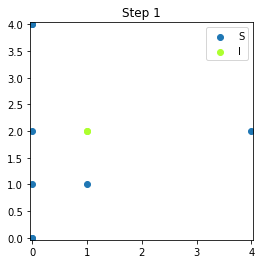

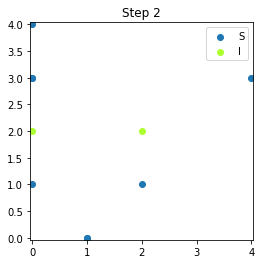

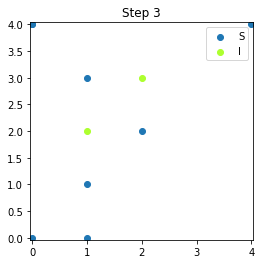

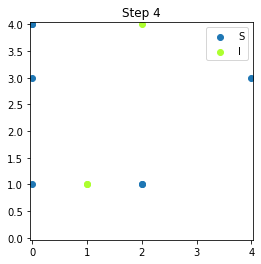

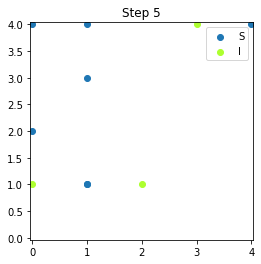

In [6]:
steps = 5
S,V,I,R = COVID_RW_single_simulation_run(no_init_infected=2,population_size=10,nx=4,ny=4,steps=steps,report_every_n_steps=1,report_infos=True)

## Exercise 2

### Part 1

In [7]:
def MCRW_SI(steps_per_run,infected=1,q=0.9):
    C2 = RandomWalkEpidemicSimulator(no_init_infected=infected,population_size=683,nx=50,ny=50,q=q)
    cols_S= []
    cols_I= []
    for j in range(steps_per_run):
        C2.f_Step()
        C2.f_Walk()
        cols_S.append(len(C2.Walkers[C2.Walkers.Status=='S']))
        cols_I.append(len(C2.Walkers[C2.Walkers.Status=='I']))
    return [cols_S,cols_I]

In [8]:
def simulation_SI(infected,q,number_of_runs = 100,steps_per_run = 300,multi=False):
    df_S = pd.DataFrame()
    df_I = pd.DataFrame()
    if multi==False:
        for i in range(number_of_runs):
            results = MCRW_SI(steps_per_run,infected=infected,q=q)
            df_S['S' + str(i)] = results[0]
            df_I['I' + str(i)] = results[1]
    else:
        npp=mp.cpu_count() 
        steps_per_runs =[steps_per_run for i in range(number_of_runs)]
        with mp.Pool(npp) as pool:         
            results = pool.map(MCRW_SI,steps_per_runs)
        for i in range(number_of_runs):
            df_S['S' + str(i)] = results[i][0]
            df_I['I' + str(i)] = results[i][1]
    return df_S , df_I

In [9]:
df_S,df_I=simulation_SI(1,0.9)

The sample mean and the sample standard deviation of the number of healthy people:

In [10]:
df_S['mean'] = df_S.mean(axis=1)
df_S['sd'] = df_S.std(axis=1)
df_S

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S92,S93,S94,S95,S96,S97,S98,S99,mean,sd
0,682,681,682,682,681,682,682,681,681,681,...,682,682,682,682,682,682,682,682,681.78,0.460000
1,681,680,682,682,681,681,682,680,681,681,...,682,679,682,682,682,682,682,682,681.57,0.710704
2,681,680,681,682,681,681,682,680,680,681,...,682,679,682,681,682,682,682,682,681.37,0.890562
3,681,680,681,682,681,681,682,676,679,681,...,682,678,682,681,682,682,682,682,681.20,1.113553
4,681,680,681,682,681,681,682,674,678,680,...,682,677,682,680,682,682,682,682,680.88,1.401999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000


The sample mean and the sample standard deviation of the number of sick people:

In [11]:
df_I['mean'] = df_I.mean(axis=1)
df_I['sd'] = df_I.std(axis=1)
df_I


,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,I92,I93,I94,I95,I96,I97,I98,I99,mean,sd
0,1,2,1,1,2,1,1,2,2,2,...,1,1,1,1,1,1,1,1,1.22,0.460000
1,2,3,1,1,2,2,1,3,2,2,...,1,4,1,1,1,1,1,1,1.43,0.710704
2,2,3,2,1,2,2,1,3,3,2,...,1,4,1,2,1,1,1,1,1.63,0.890562
3,2,3,2,1,2,2,1,7,4,2,...,1,5,1,2,1,1,1,1,1.80,1.113553
4,2,3,2,1,2,2,1,9,5,3,...,1,6,1,3,1,1,1,1,2.12,1.401999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,683,683,683,683,683,683,683,683,683,683,...,683,683,683,683,683,683,683,683,683.00,0.000000
296,683,683,683,683,683,683,683,683,683,683,...,683,683,683,683,683,683,683,683,683.00,0.000000
297,683,683,683,683,683,683,683,683,683,683,...,683,683,683,683,683,683,683,683,683.00,0.000000
298,683,683,683,683,683,683,683,683,683,683,...,683,683,683,683,683,683,683,683,683.00,0.000000


The figure showing the expected time-development of healthy and sick people:

In [12]:
def plot_SI_RW(S_mean,I_mean,S_sd,I_sd,x):
    fig, ax = plt.subplots()
    ax.plot(S_mean,label = 'Susceptible - RW')
    ax.plot(S_mean-S_sd,color = 'gray' ,alpha=0.2)
    ax.plot(S_mean+S_sd,color = 'gray' ,alpha=0.2)
    ax.plot(I_mean,label = 'Infected - RW',c='greenyellow')
    ax.plot(I_mean-I_sd,color = 'gray' ,alpha=0.2)
    ax.plot(I_mean+I_sd,color = 'gray' ,alpha=0.2)
    ax.fill_between(x,S_mean,S_mean-S_sd,color='gray', alpha=0.2)
    ax.fill_between(x,S_mean,S_mean+S_sd,color='gray', alpha=0.2)
    ax.fill_between(x,I_mean,I_mean-I_sd,color='gray', alpha=0.2)
    ax.fill_between(x,I_mean,I_mean+I_sd,color='gray', alpha=0.2)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Population')
    ax.grid()
    ax.legend()
    return fig


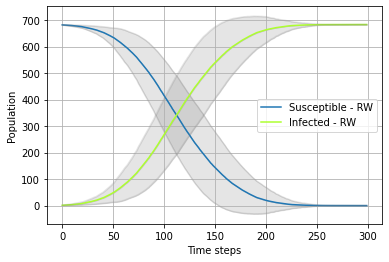

In [13]:
x = np.arange(0,300)
f = plot_SI_RW(df_S['mean'],df_I['mean'],df_S['sd'],df_I['sd'],x)


### Part 2

In [14]:
df_S10,df_I10=simulation_SI(10,0.9)

In [15]:
df_S10['mean'] = df_S10.mean(axis=1)
df_S10['sd'] = df_S10.std(axis=1)
df_S10

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S92,S93,S94,S95,S96,S97,S98,S99,mean,sd
0,668,669,668,671,670,672,673,664,670,666,...,670,671,658,667,670,672,670,666,669.26,3.419415
1,661,655,663,671,666,670,669,662,669,664,...,669,669,653,665,669,671,667,665,665.72,5.822508
2,649,647,659,669,666,670,667,662,665,663,...,668,666,644,659,668,670,665,662,662.36,7.294546
3,642,647,653,661,663,668,666,643,662,655,...,668,662,631,652,664,668,663,660,657.93,9.990250
4,635,637,647,658,661,668,654,643,658,652,...,668,661,625,643,664,668,659,659,653.59,11.648257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000


In [16]:
df_I10['mean'] = df_I10.mean(axis=1)
df_I10['sd'] = df_I10.std(axis=1)
df_I10

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,I92,I93,I94,I95,I96,I97,I98,I99,mean,sd
0,15,14,15,12,13,11,10,19,13,17,...,13,12,25,16,13,11,13,17,13.74,3.419415
1,22,28,20,12,17,13,14,21,14,19,...,14,14,30,18,14,12,16,18,17.28,5.822508
2,34,36,24,14,17,13,16,21,18,20,...,15,17,39,24,15,13,18,21,20.64,7.294546
3,41,36,30,22,20,15,17,40,21,28,...,15,21,52,31,19,15,20,23,25.07,9.990250
4,48,46,36,25,22,15,29,40,25,31,...,15,22,58,40,19,15,24,24,29.41,11.648257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,683,683,683,683,683,683,683,683,683,683,...,683,683,683,683,683,683,683,683,683.00,0.000000
296,683,683,683,683,683,683,683,683,683,683,...,683,683,683,683,683,683,683,683,683.00,0.000000
297,683,683,683,683,683,683,683,683,683,683,...,683,683,683,683,683,683,683,683,683.00,0.000000
298,683,683,683,683,683,683,683,683,683,683,...,683,683,683,683,683,683,683,683,683.00,0.000000


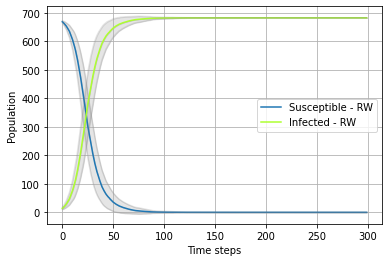

In [17]:
x = np.arange(0,300)
f10 = plot_SI_RW(df_S10['mean'],df_I10['mean'],df_S10['sd'],df_I10['sd'],x)


As expected, by increasing the number of initial infected people the disease would spread faster, as there are more infected people meeting susceptible people in the beginning and therefore spreading it to more people faster.

### Part 3

In [18]:
def beta_delta_t(S,I,N):
    res_beta_delta_t=[]
    for i in range(1,300):
        Sdif = S[i]-S[i-1]
        temp = S[i]*I[i]
        if temp == 0:
            beta_delta_t = 0
        else:
            beta_delta_t= (-Sdif*N)/temp
        res_beta_delta_t.append(beta_delta_t)
    return res_beta_delta_t

beta_delta_t_arr = []
for i in range(100):
    beta_delta_t_arr.append(beta_delta_t(np.array(df_S['S'+str(i)]),np.array(df_I['I'+str(i)]),683))


In [19]:
beta_delta_t_arr = np.array(beta_delta_t_arr)
mean_beta = np.mean(beta_delta_t_arr)
mean_non_zero_beta = np.mean(beta_delta_t_arr[beta_delta_t_arr>0])
median_non_zero_beta = np.median(beta_delta_t_arr[beta_delta_t_arr>0])
print('mean_beta',mean_beta,'\nmean_non_zero_beta',mean_non_zero_beta,'\nmedian_non_zero_beta',median_non_zero_beta)

mean_beta 0.04406478605496358 
mean_non_zero_beta 0.09401577729723212 
median_non_zero_beta 0.05814975333758271


In [20]:
def SI_analytical(N,time,I0,beta):
    S0 = N - I0
    return N/(1+(S0/I0)*np.exp(-beta*time))


In [21]:
N= 683
t = np.arange(0,300,1)
I_mean_beta= SI_analytical(N,t,1,mean_beta)
I_mean_non_zero_beta= SI_analytical(N,t,1,mean_non_zero_beta)
I_median_non_zero_beta= SI_analytical(N,t,1,median_non_zero_beta)

In [22]:
def plot_SI_analytical_RW(I1,I2,I3,I4):
    plt.plot(I1,label='Beta = mean of all beta')
    plt.plot(I2,label='Beta = mean of non zero beta')
    plt.plot(I3,label='Beta = median of non zero beta')
    plt.plot(I4,label='Average of RW infected')
    plt.xlabel('Time steps')
    plt.ylabel('Population')
    plt.title('Infected population')
    plt.legend()
    plt.grid()

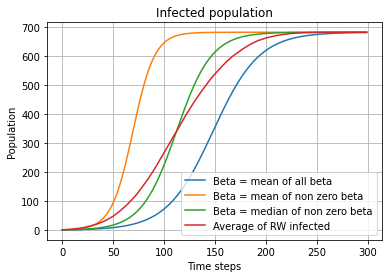

In [23]:
plot_SI_analytical_RW(I_mean_beta,I_mean_non_zero_beta,I_median_non_zero_beta,df_I['mean'])

The random walk algorithm is a stochastic process, therefore the average number of infected using this algorithm is not completley the same as the analytical solution to the SI-model. This is also due to the assumption of beta being constant. Finding an analytical function that describes
the average trend in the "observed" beta from the random walk would help in fitting the analytical SI-Model better to the random walk result. However, running the analytical solution to the SI-model using the median of the distribution of non zero betas gets a pretty close result.

### Part 4

Increase the number of initially infected people to 10.

In [24]:
beta10_delta_t_arr = []
for i in range(100):
    beta10_delta_t_arr.append(beta_delta_t(np.array(df_S10['S'+str(i)]),np.array(df_I10['I'+str(i)]),683))

In [25]:
beta10_delta_t_arr = np.array(beta10_delta_t_arr)
mean_beta10 = np.mean(beta10_delta_t_arr)
mean_non_zero_beta10 = np.mean(beta10_delta_t_arr[beta10_delta_t_arr>0])
median_non_zero_beta10 = np.median(beta10_delta_t_arr[beta10_delta_t_arr>0])
print('mean_beta10',mean_beta10,'\nmean_non_zero_beta10',mean_non_zero_beta10,'\nmedian_non_zero_beta10',median_non_zero_beta10)

mean_beta10 0.03681612956906588 
mean_non_zero_beta10 0.18544512704094843 
median_non_zero_beta10 0.14815809897759835


In [26]:
N= 683
t = np.arange(0,300,1)
I10_mean_beta= SI_analytical(N,t,10,mean_beta10)
I10_mean_non_zero_beta= SI_analytical(N,t,10,mean_non_zero_beta10)
I10_median_non_zero_beta= SI_analytical(N,t,10,median_non_zero_beta10)

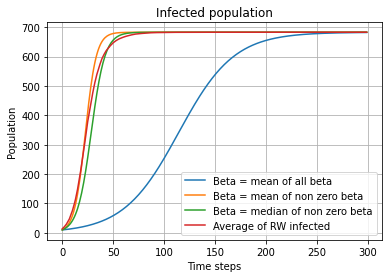

In [27]:
plot_SI_analytical_RW(I10_mean_beta,I10_mean_non_zero_beta,I10_median_non_zero_beta,df_I10['mean'])

With a higher number of initially infected people both analytical SI-model solutions with beta as mean and as median of non zero betas get closer to the results of the random walk simulation. This is because there is less variance in how long it takes the initial infected people to encounter and infect the next people.

Reduce q to 0.45.

In [28]:
df_q_S10,df_q_I10=simulation_SI(10,0.45)

In [29]:
df_q_S10['mean'] = df_q_S10.mean(axis=1)
df_q_S10['sd'] = df_q_S10.std(axis=1)
df_q_I10['mean'] = df_q_I10.mean(axis=1)
df_q_I10['sd'] = df_q_I10.std(axis=1)


In [30]:
beta10_q_delta_t_arr = []
for i in range(100):
    beta10_q_delta_t_arr.append(beta_delta_t(np.array(df_q_S10['S'+str(i)]),np.array(df_q_I10['I'+str(i)]),683))

In [31]:
beta10_q_delta_t_arr = np.array(beta10_q_delta_t_arr)
mean_beta10_q = np.mean(beta10_q_delta_t_arr)
mean_non_zero_beta10_q = np.mean(beta10_q_delta_t_arr[beta10_q_delta_t_arr>0])
median_non_zero_beta10_q = np.median(beta10_q_delta_t_arr[beta10_q_delta_t_arr>0])
print('mean_beta10_q',mean_beta10_q,'\nmean_non_zero_beta10_q',mean_non_zero_beta10_q,'\nmedian_non_zero_beta10_q',median_non_zero_beta10_q)

mean_beta10_q 0.03772013610354739 
mean_non_zero_beta10_q 0.25141151794384015 
median_non_zero_beta10_q 0.20449101796407185


In [32]:
N= 683
t = np.arange(0,300,1)
I10_q_mean_beta= SI_analytical(N,t,10,mean_beta10_q)
I10_q_mean_non_zero_beta= SI_analytical(N,t,10,mean_non_zero_beta10_q)
I10_q_median_non_zero_beta= SI_analytical(N,t,10,median_non_zero_beta10_q)

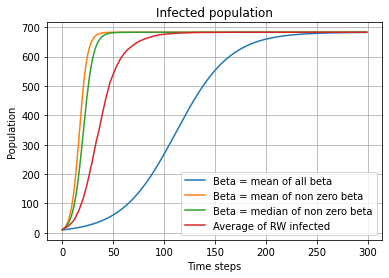

In [33]:
plot_SI_analytical_RW(I10_q_mean_beta,I10_q_mean_non_zero_beta,I10_q_median_non_zero_beta,df_q_I10['mean'])

When decreasing the infection probability the analytical solutions to the SI-model are reaching full infection in the population faster than the random walk simulation. This is because in the analytical SI-model q is not a separate parameter, but combined with the encounter probability p of susceptible and infected people meeting into beta. If q is close to 1 (as in 0.9) beta primarily represents p and therefore gives a good representation of the Infection developement of the random walk. if q is reduced this representation becomes less accurate and therefore the analytical solution to the SI-model will fit the random walk simulation not as good.

## Exercise 3

### Part 1

In [34]:
def MCRW_SIR(steps_per_run,infected=1,q=0.9,precover=0.01):
  C2 = RandomWalkEpidemicSimulator(no_init_infected=infected,population_size=683,nx=50,ny=50,q=q,precover=precover)
  cols_S= []
  cols_I= []
  cols_R = []
  for j in range(steps_per_run):
    C2.f_Step()
    C2.f_Walk(precover =precover)
    cols_S.append(len(C2.Walkers[C2.Walkers.Status=='S']))
    cols_I.append(len(C2.Walkers[C2.Walkers.Status=='I']))
    cols_R.append(len(C2.Walkers[C2.Walkers.Status=='R']))
  return [cols_S,cols_I,cols_R]

In [35]:
def simulation_SIR(infected,q,precover,number_of_runs = 100,steps_per_run = 300,multi=False):
    df2_S = pd.DataFrame()
    df2_I = pd.DataFrame()
    df_R = pd.DataFrame()
    if multi==False:
        for i in range(number_of_runs):
            results = MCRW_SIR(steps_per_run,infected=infected,q=q,precover=precover)
            df2_S['S' + str(i)] = results[0]
            df2_I['I' + str(i)] = results[1]
            df_R['R' + str(i)] = results[2] 
    else:
        npp=mp.cpu_count() 
        steps_per_runs =[steps_per_run for i in range(number_of_runs)]     
        with mp.Pool(npp) as pool:         
            results = pool.map(MCRW_SIR, steps_per_runs)

        for i in range(number_of_runs):
            df2_S['S' + str(i)] = results[i][0]
            df2_I['I' + str(i)] = results[i][1]
            df_R['R' + str(i)] = results[i][2]
    return df2_S , df2_I, df_R

### Part 2

In [36]:
df2_S,df2_I,df_R = simulation_SIR(1,0.9,0.01)

In [37]:
df2_S['mean'] = df2_S.mean(axis=1)
df2_S['sd'] = df2_S.std(axis=1)
df2_S

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S92,S93,S94,S95,S96,S97,S98,S99,mean,sd
0,682,682,682,681,682,682,682,682,682,682,...,681,682,681,682,682,682,682,682,681.75,0.455522
1,682,682,682,681,682,682,682,682,682,681,...,681,682,680,682,681,682,682,682,681.51,0.714073
2,682,682,680,678,682,682,682,682,682,681,...,680,682,680,682,679,681,682,682,681.24,1.011138
3,682,682,680,678,682,681,682,682,681,681,...,680,682,680,682,679,681,682,682,680.97,1.284173
4,682,682,680,677,682,681,682,682,680,681,...,680,682,679,682,679,681,682,682,680.75,1.485766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1,5,0,0,1,4,0,1,0,0,...,0,1,1,0,1,0,0,0,20.95,116.258107
296,1,5,0,0,1,4,0,0,0,0,...,0,1,1,0,1,0,0,0,20.93,116.261624
297,1,5,0,0,1,4,0,0,0,0,...,0,1,1,0,1,0,0,0,20.91,116.264964
298,1,5,0,0,0,4,0,0,0,0,...,0,1,1,0,1,0,0,0,20.89,116.268215


In [38]:
df2_I['mean'] = df2_I.mean(axis=1)
df2_I['sd'] = df2_I.std(axis=1)
df2_I

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,I92,I93,I94,I95,I96,I97,I98,I99,mean,sd
0,1,1,1,2,1,1,1,1,1,1,...,2,1,2,1,1,1,1,1,1.23,0.465940
1,1,1,1,2,1,1,1,1,1,2,...,2,1,3,1,2,1,1,1,1.48,0.727736
2,1,1,3,5,1,1,1,1,1,2,...,3,1,3,1,4,2,1,1,1.74,1.016071
3,1,1,3,5,1,2,1,1,2,2,...,3,1,3,1,4,2,1,1,2.00,1.296148
4,1,1,2,6,1,2,1,1,3,2,...,3,1,4,1,3,2,1,1,2.20,1.489966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,175,279,111,114,177,175,146,126,96,174,...,128,245,225,162,132,158,127,131,148.52,56.601675
296,173,277,111,114,173,173,145,127,95,172,...,128,243,220,161,131,158,127,130,147.17,56.208194
297,171,276,109,112,171,172,145,122,95,171,...,128,242,218,161,127,156,126,130,145.93,55.813127
298,167,273,106,112,170,172,143,121,95,168,...,128,242,216,159,126,154,124,129,144.45,55.220173


In [39]:
df_R['mean'] = df_R.mean(axis=1)
df_R['sd'] = df_R.std(axis=1)
df_R

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R92,R93,R94,R95,R96,R97,R98,R99,mean,sd
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.02,0.140000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.01,0.099499
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.02,0.140000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.03,0.170587
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.05,0.217945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,507,399,572,569,505,504,537,556,587,509,...,555,437,457,521,550,525,556,552,513.53,103.394144
296,509,401,572,569,509,506,538,556,588,511,...,555,439,462,522,551,525,556,553,514.90,103.452839
297,511,402,574,571,511,507,538,561,588,512,...,555,440,464,522,555,527,557,553,516.16,103.477120
298,515,405,577,571,513,507,540,562,588,515,...,555,440,466,524,556,529,559,554,517.66,103.434735


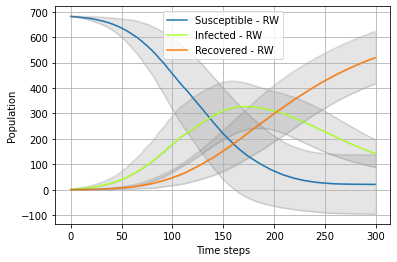

In [40]:
fig = plot_SI_RW(df2_S['mean'],df2_I['mean'],df2_S['sd'],df2_I['sd'],x)
ax = fig.axes[0]
ax.plot(df_R['mean'],label='Recovered - RW',c='tab:orange')
ax.plot(df_R['mean']-df_R['sd'],color = 'gray' ,alpha=0.2)
ax.plot(df_R['mean']+df_R['sd'],color = 'gray' ,alpha=0.2)
ax.fill_between(x,df_R['mean'],df_R['mean']-df_R['sd'],color='gray', alpha=0.2)
ax.fill_between(x,df_R['mean'],df_R['mean']+df_R['sd'],color='gray', alpha=0.2)
ax.legend()

### Part 3

In [41]:
df2_PR_S,df2_PR_I,df_PR_R = simulation_SIR(1,0.9,0.1)

In [42]:
df2_PR_S['mean'] = df2_PR_S.mean(axis=1)
df2_PR_S['sd'] = df2_PR_S.std(axis=1)
df2_PR_S

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S92,S93,S94,S95,S96,S97,S98,S99,mean,sd
0,682,682,682,682,682,681,682,682,681,682,...,682,681,682,682,680,682,682,682,681.83,0.448442
1,682,682,681,682,682,681,681,682,680,682,...,682,681,682,682,679,681,682,682,681.59,0.722426
2,681,682,681,682,682,681,681,682,680,682,...,682,681,682,682,679,681,682,682,681.41,0.939095
3,681,682,681,682,682,681,681,682,680,682,...,682,680,682,681,679,681,681,682,681.23,1.255826
4,681,682,679,682,682,681,681,681,680,682,...,682,680,682,681,679,681,681,682,681.09,1.312212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,677,682,661,674,682,681,671,669,671,642,...,682,676,682,680,675,678,679,682,676.08,9.931445
296,677,682,661,674,682,681,671,669,671,642,...,682,676,682,680,675,678,679,682,676.08,9.931445
297,677,682,661,674,682,681,671,669,671,642,...,682,676,682,680,675,678,679,682,676.08,9.931445
298,677,682,661,674,682,681,671,669,671,642,...,682,676,682,680,675,678,679,682,676.08,9.931445


In [43]:
df2_PR_I['mean'] = df2_PR_I.mean(axis=1)
df2_PR_I['sd'] = df2_PR_I.std(axis=1)
df2_PR_I

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,I92,I93,I94,I95,I96,I97,I98,I99,mean,sd
0,1,0,1,1,1,2,1,1,2,1,...,1,2,0,1,2,1,1,0,1.03,0.499099
1,1,0,2,1,1,1,2,1,3,1,...,1,2,0,1,4,2,1,0,1.14,0.824864
2,2,0,2,1,0,1,2,1,3,1,...,1,2,0,1,4,2,1,0,1.22,1.044797
3,2,0,2,1,0,1,2,1,3,1,...,0,3,0,2,2,2,2,0,1.28,1.233532
4,2,0,4,1,0,1,1,2,3,1,...,0,3,0,2,2,2,2,0,1.27,1.279492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000


In [44]:
df_PR_R['mean'] = df_PR_R.mean(axis=1)
df_PR_R['sd'] = df_PR_R.std(axis=1)
df_PR_R

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R92,R93,R94,R95,R96,R97,R98,R99,mean,sd
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0.14,0.374700
1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0.27,0.465940
2,0,1,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0.37,0.503090
3,0,1,0,0,1,1,0,0,0,0,...,1,0,1,0,2,0,0,1,0.49,0.556687
4,0,1,0,0,1,1,1,0,0,0,...,1,0,1,0,2,0,0,1,0.64,0.671118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,6,1,22,9,1,2,12,14,12,41,...,1,7,1,3,8,5,4,1,6.92,9.931445
296,6,1,22,9,1,2,12,14,12,41,...,1,7,1,3,8,5,4,1,6.92,9.931445
297,6,1,22,9,1,2,12,14,12,41,...,1,7,1,3,8,5,4,1,6.92,9.931445
298,6,1,22,9,1,2,12,14,12,41,...,1,7,1,3,8,5,4,1,6.92,9.931445


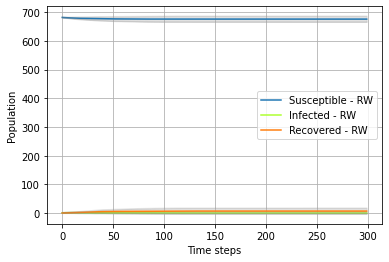

In [45]:
fig = plot_SI_RW(df2_PR_S['mean'],df2_PR_I['mean'],df2_PR_S['sd'],df2_PR_I['sd'],x)
ax = fig.axes[0]
ax.plot(df_PR_R['mean'],label='Recovered - RW',c='tab:orange')
ax.plot(df_PR_R['mean']-df_PR_R['sd'],color = 'gray' ,alpha=0.2)
ax.plot(df_PR_R['mean']+df_PR_R['sd'],color = 'gray' ,alpha=0.2)
ax.fill_between(x,df_PR_R['mean'],df_PR_R['mean']-df_PR_R['sd'],color='gray', alpha=0.2)
ax.fill_between(x,df_PR_R['mean'],df_PR_R['mean']+df_PR_R['sd'],color='gray', alpha=0.2)
ax.legend()

As the number of initial infected people is only 1, by increasing the probability of recovery, the few infected people recover fast and soon there are no infected people left to spread the disease, because they already recovered. 

For the disease to be able to spread again, we need to increase the initial infected people or decrease the probability of recovery.

Increase the number of initially infected people to 10

In [46]:
df3_PR_S,df3_PR_I,df2_PR_R = simulation_SIR(10,0.9,0.1)

In [47]:
df3_PR_S['mean'] = df3_PR_S.mean(axis=1)
df3_PR_S['sd'] = df3_PR_S.std(axis=1)
df3_PR_S

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S92,S93,S94,S95,S96,S97,S98,S99,mean,sd
0,669,666,670,669,668,670,667,664,671,673,...,672,656,672,668,669,671,664,672,670.13,2.927986
1,666,660,663,663,662,669,667,655,669,668,...,671,655,672,668,668,668,657,670,667.01,4.650796
2,663,659,662,656,662,668,662,653,668,666,...,671,644,671,664,666,667,651,670,664.30,6.135960
3,657,658,662,651,658,666,660,653,667,663,...,671,636,670,661,660,663,649,670,661.66,7.474249
4,655,656,653,647,657,666,657,649,662,658,...,671,633,668,659,660,662,647,669,659.06,8.617215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,544,611,520,610,482,630,465,531,543,594,...,598,471,611,617,453,636,331,618,549.02,107.363213
296,544,611,520,610,482,630,465,531,543,594,...,598,471,611,617,453,636,331,618,549.02,107.363213
297,544,611,520,610,482,630,465,531,543,594,...,598,471,611,617,453,636,331,618,549.02,107.363213
298,544,611,520,610,482,630,465,531,543,594,...,598,471,611,617,453,636,331,618,549.02,107.363213


In [48]:
df3_PR_I['mean'] = df3_PR_I.mean(axis=1)
df3_PR_I['sd'] = df3_PR_I.std(axis=1)
df3_PR_I

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,I92,I93,I94,I95,I96,I97,I98,I99,mean,sd
0,12,16,13,14,13,12,15,17,11,9,...,10,21,11,14,13,11,17,10,11.49,2.758605
1,13,21,16,16,15,11,15,22,12,13,...,11,20,11,12,12,14,23,10,13.12,4.147963
2,16,18,13,21,13,10,16,22,12,13,...,7,28,10,15,13,13,28,10,14.29,5.455813
3,19,18,11,21,16,10,18,22,12,13,...,6,32,10,14,15,13,28,10,15.09,6.251552
4,20,18,19,25,16,8,19,24,15,19,...,6,32,12,14,13,14,24,11,16.01,6.899993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000
298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000000


In [49]:
df2_PR_R['mean'] = df2_PR_R.mean(axis=1)
df2_PR_R['sd'] = df2_PR_R.std(axis=1)
df2_PR_R

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R92,R93,R94,R95,R96,R97,R98,R99,mean,sd
0,2,1,0,0,2,1,1,2,1,1,...,1,6,0,1,1,1,2,1,1.38,1.007770
1,4,2,4,4,6,3,1,6,2,2,...,1,8,0,3,3,1,3,3,2.87,1.706781
2,4,6,8,6,8,5,5,8,3,4,...,5,11,2,4,4,3,4,3,4.41,1.975323
3,7,7,10,11,9,7,5,8,4,7,...,6,15,3,8,8,7,6,3,6.25,2.389037
4,8,9,11,11,10,9,7,10,6,6,...,6,18,3,10,10,7,12,3,7.93,3.000850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,139,72,163,73,201,53,218,152,140,89,...,85,212,72,66,230,47,352,65,133.98,107.363213
296,139,72,163,73,201,53,218,152,140,89,...,85,212,72,66,230,47,352,65,133.98,107.363213
297,139,72,163,73,201,53,218,152,140,89,...,85,212,72,66,230,47,352,65,133.98,107.363213
298,139,72,163,73,201,53,218,152,140,89,...,85,212,72,66,230,47,352,65,133.98,107.363213


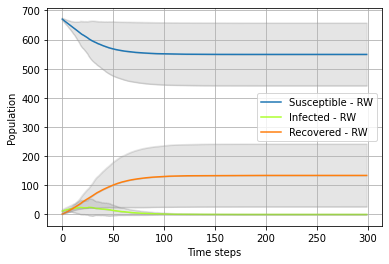

In [50]:
fig = plot_SI_RW(df3_PR_S['mean'],df3_PR_I['mean'],df3_PR_S['sd'],df3_PR_I['sd'],x)
ax = fig.axes[0]
ax.plot(df2_PR_R['mean'],label='Recovered - RW',c='tab:orange')
ax.plot(df2_PR_R['mean']-df2_PR_R['sd'],color = 'gray' ,alpha=0.2)
ax.plot(df2_PR_R['mean']+df2_PR_R['sd'],color = 'gray' ,alpha=0.2)
ax.fill_between(x,df2_PR_R['mean'],df2_PR_R['mean']-df2_PR_R['sd'],color='gray', alpha=0.2)
ax.fill_between(x,df2_PR_R['mean'],df2_PR_R['mean']+df2_PR_R['sd'],color='gray', alpha=0.2)
ax.legend()

The plot above shows that by increasing the number of initially infected to 10 the disease is allowed to spread a bit again, but because of the still high recovery rate only a small portion of the population gets infected and most of them remain susceptable with all infected having recovered in the end.

### Part 4

In [51]:
def tau(R,I):
    res_tau_delta_t=[]
    for i in range(1,300):
        Rdif = R[i]-R[i-1]
        if Rdif == 0:
            tau = 0
        else:
            tau= I[i]/Rdif
        res_tau_delta_t.append(tau)
    return res_tau_delta_t

tau_delta_t_arr = []
for i in range(100):
    tau_delta_t_arr.append(tau(np.array(df_R['R'+str(i)]),np.array(df2_I['I'+str(i)])))


In [52]:
tau_delta_t_arr = np.array(tau_delta_t_arr)
tau_delta_t_arr = tau_delta_t_arr[tau_delta_t_arr>0]
mean_tau = np.mean(tau_delta_t_arr)
print("Average value for tau: "+str(round(mean_tau,2)))
print("Average value for beta: "+str(round(median_non_zero_beta,4)))

Average value for tau: 117.27
Average value for beta: 0.0581


In [53]:
R0 = median_non_zero_beta * mean_tau
print('R0 =',round(R0,2))

R0 = 6.82


As R0 = beta * tau_sick, a higher basic reproduction number means higher transmission rates and longer recovery times. This means with a higher basic reproduction number an infected person is more likely to infect susceptible people and will have more time until recovered to infect further people. Therefore the expected number of secondary infections is higher.

### Part 5

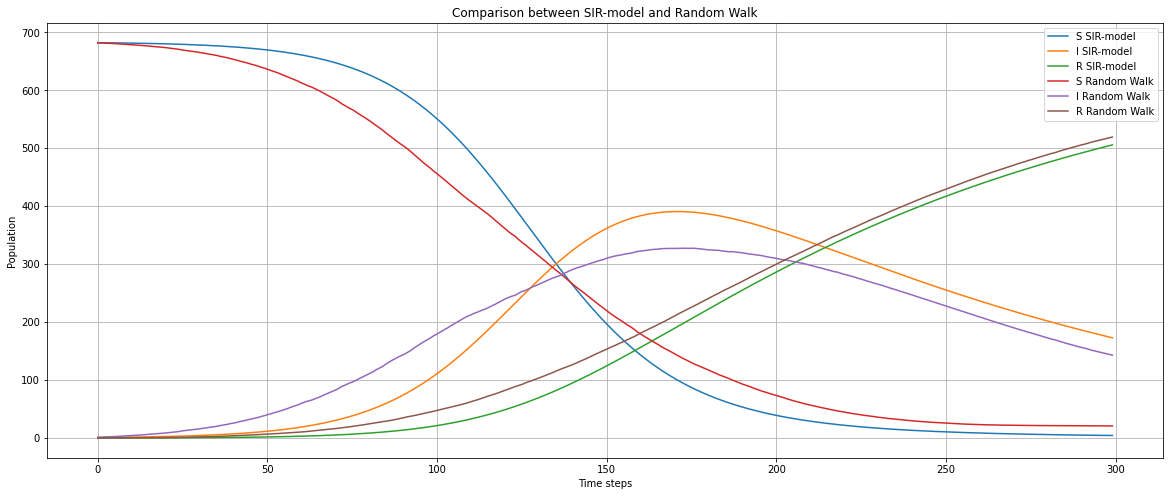

In [54]:
def SIR_model(t, *, beta, tau_s, N=683, I0=1, R0=0):

    def rhs(X, t):
        S, I, R = X
        return [-beta*S*I/N, +beta*S*I/N - I/tau_s, +I/tau_s]

    X0 = [N-I0-R0, I0, R0]
    sol = sp.integrate.odeint(rhs, X0, t)
    return sol


t = np.arange(0,300,1)
result = SIR_model(t,beta = median_non_zero_beta,tau_s = mean_tau)
result
plt.figure(figsize = [20,8])
plt.plot(result,label='SIR-model')
plt.plot(df2_S['mean'],label = 'Susceptible - RW')
plt.plot(df2_I['mean'],label = 'Infected - RW')
plt.plot(df_R['mean'],label = 'Recovered - RW')
plt.xlabel('Time steps')
plt.ylabel('Population')
plt.title('Comparison between SIR-model and Random Walk')
plt.legend(labels=['S SIR-model','I SIR-model','R SIR-model','S Random Walk','I Random Walk','R Random Walk'])
plt.grid()

As mentioned in previous parts, the stochastic random walk algorithm will not match the deterministic SIR-model perfectly. However, as the plot above shows, by choosing good average estimations for beta and tau_sick, the deterministic SIR-model can fit the random walk simulation quite well. By implementing time-sensitive functions for finding a good match for beta and tau_sick this could be improved further.

## Exercise 4

The introduction of vaccinations is introduced by randomly changing the infection status of people from susceptible to vaccinated. Vaccinated people are not susceptible for being infected when meeting infected people. 

The vaccination rate is controlled using the pvaccinate parameter. Setting it to 0 means no vaccination is introduced. 

The percentage of the population that has to become infected before the vaccine is introduced is controlled using the crit_pop_percentage parameter. Setting it to 0 means it is introduced right at the beginning of the outbreak.

### Introducing the Vaccine at the Beginning of the Outbreak

Below the initial scenario from Exercise 3 Part 2 is taken with a vaccination rate of pvaccinate = 0.01. 

By setting crit_pop_percentage to 0 the vaccine is introduced right at the beginning of the outbreak.

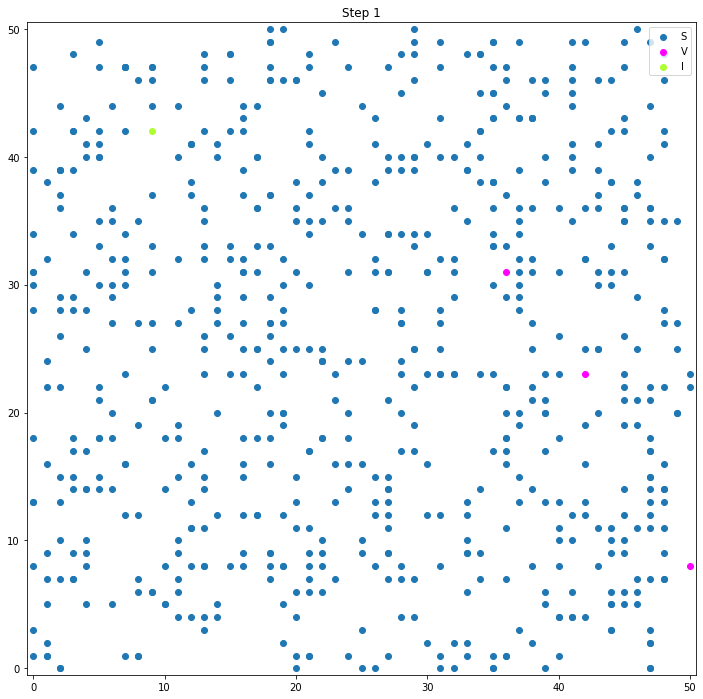

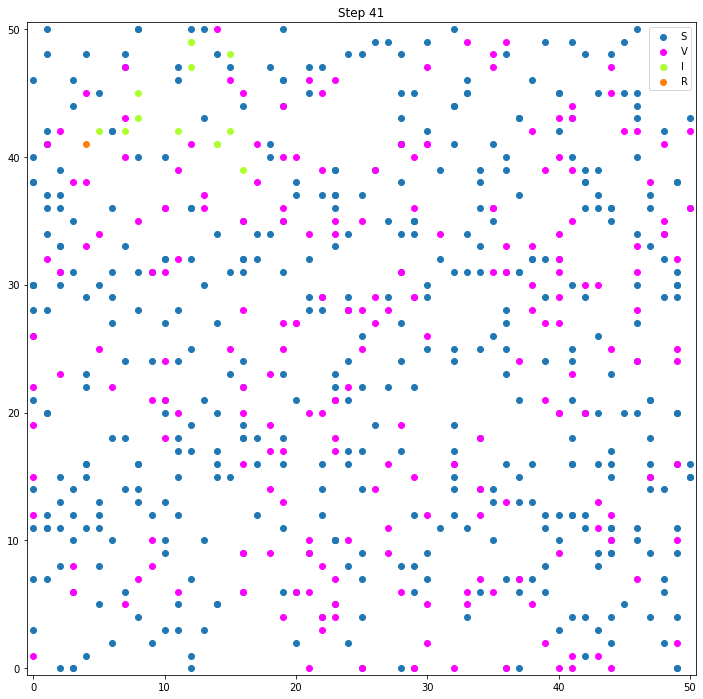

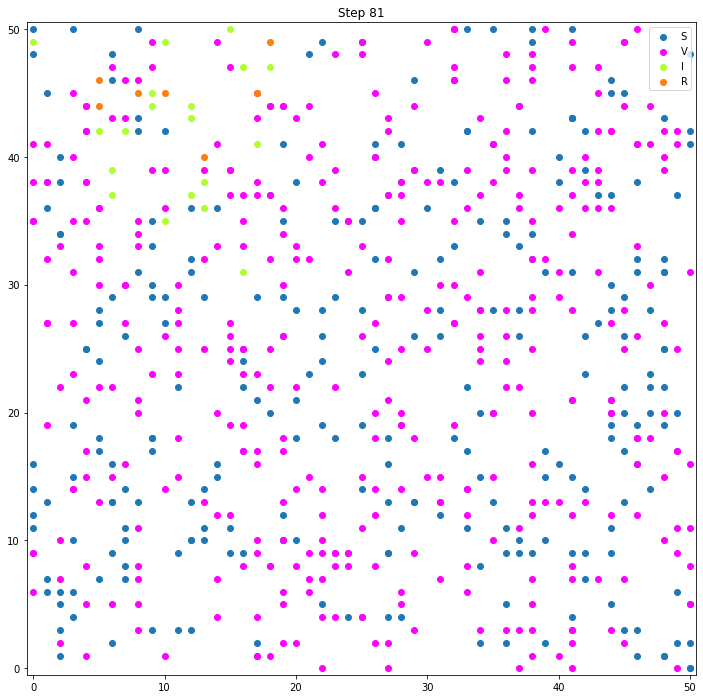

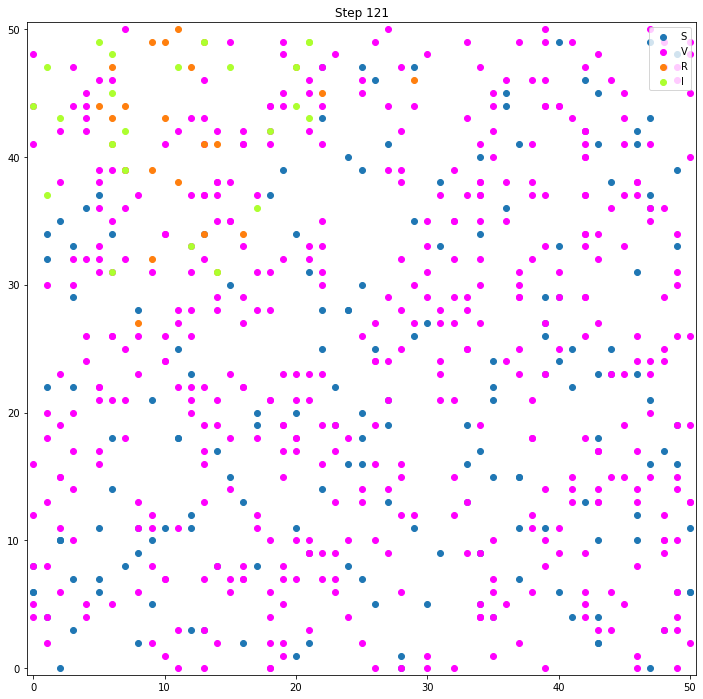

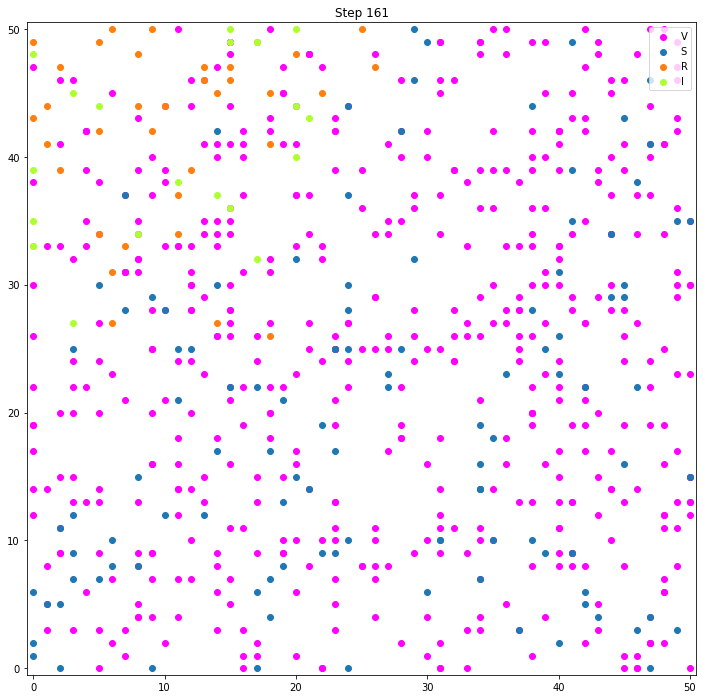

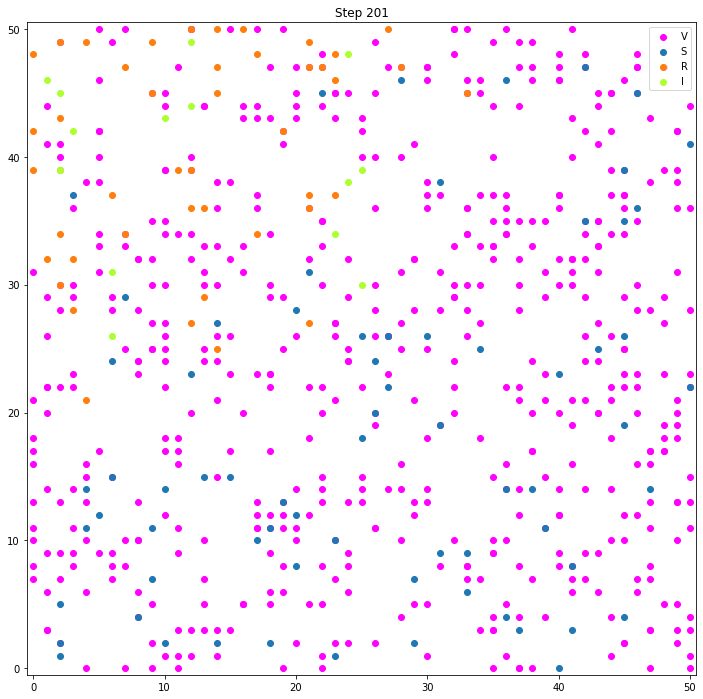

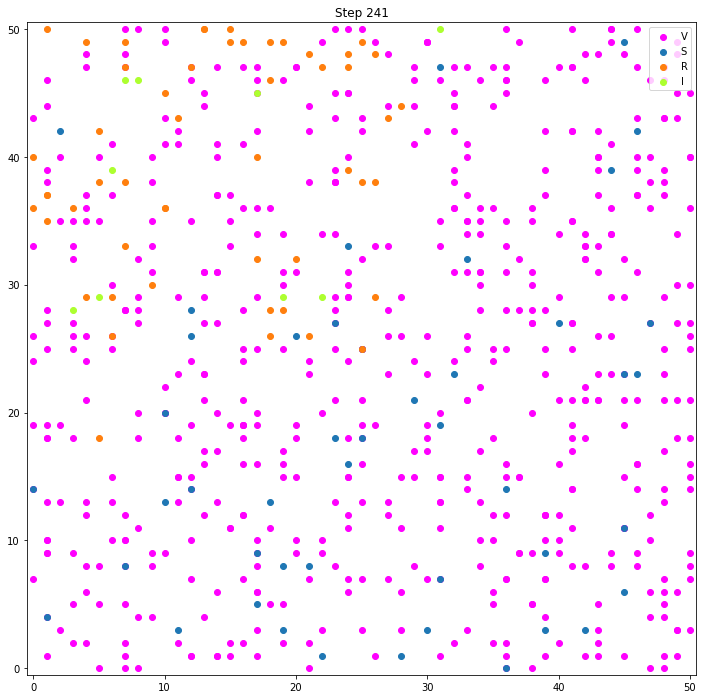

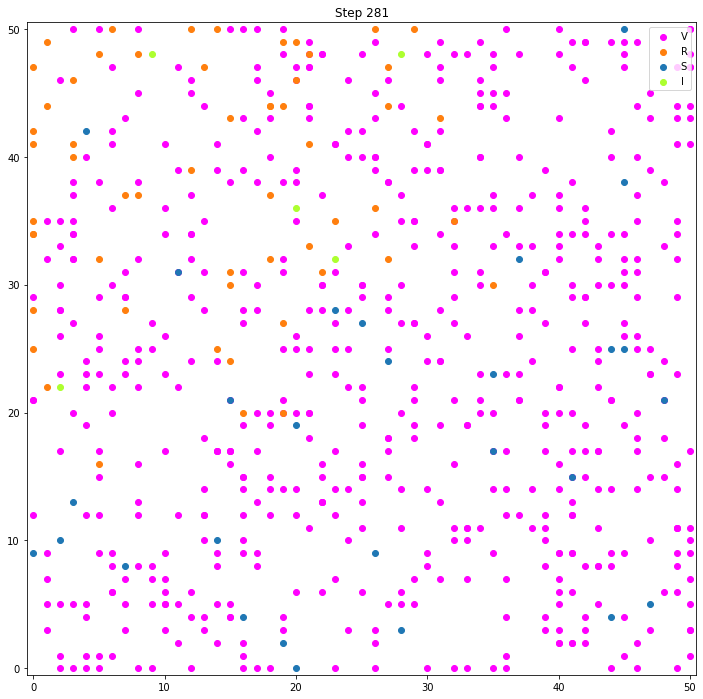

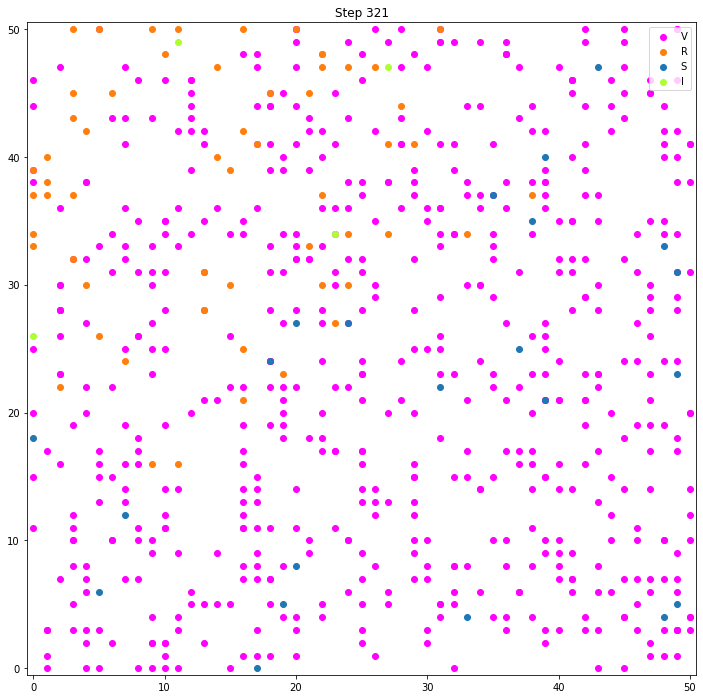

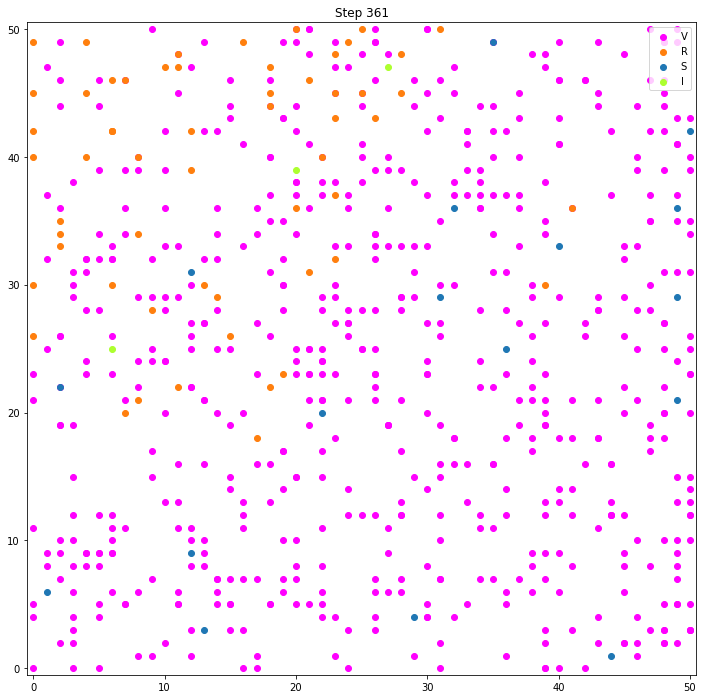

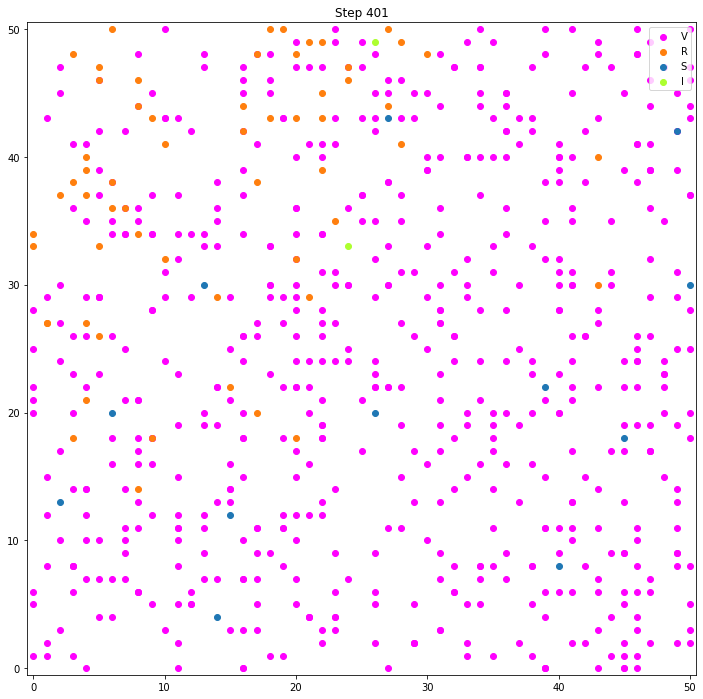

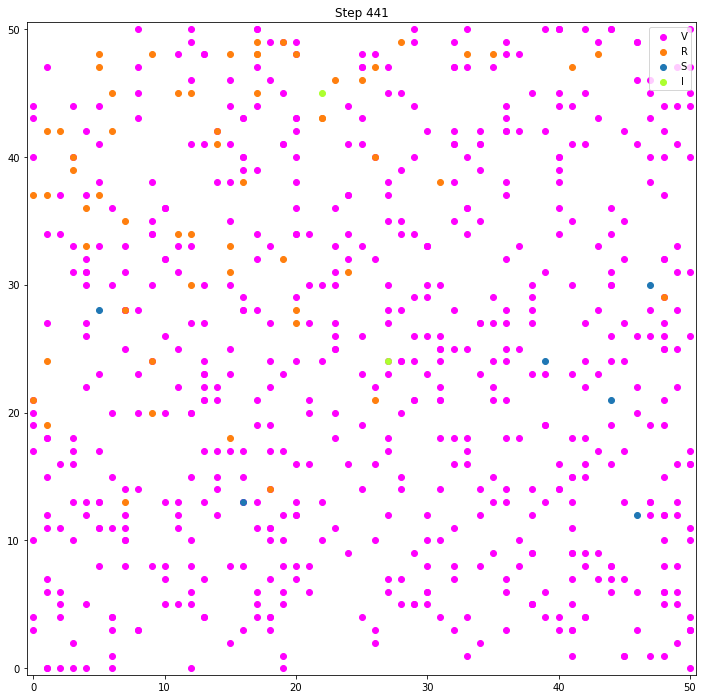

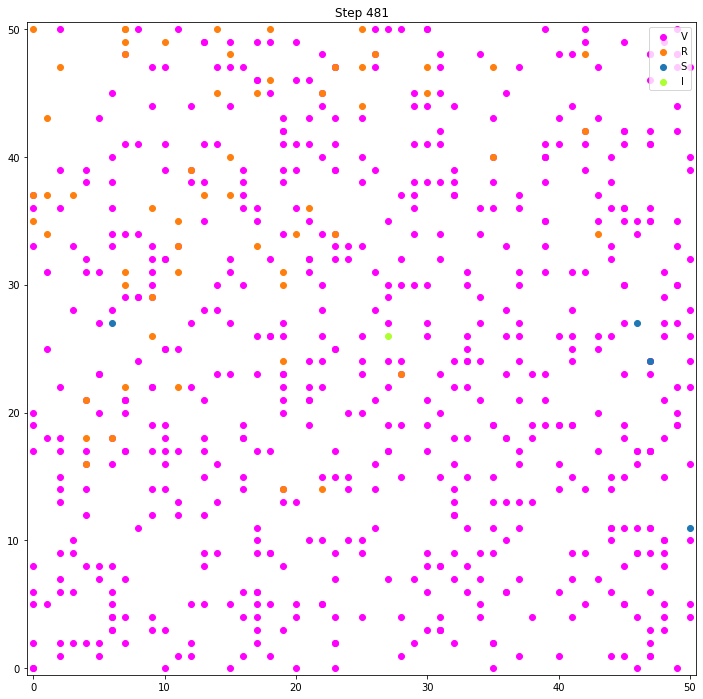

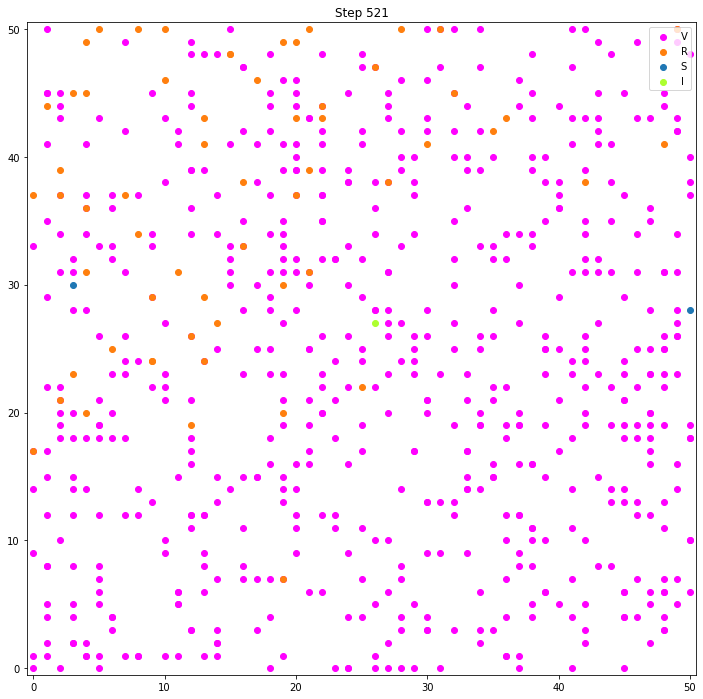

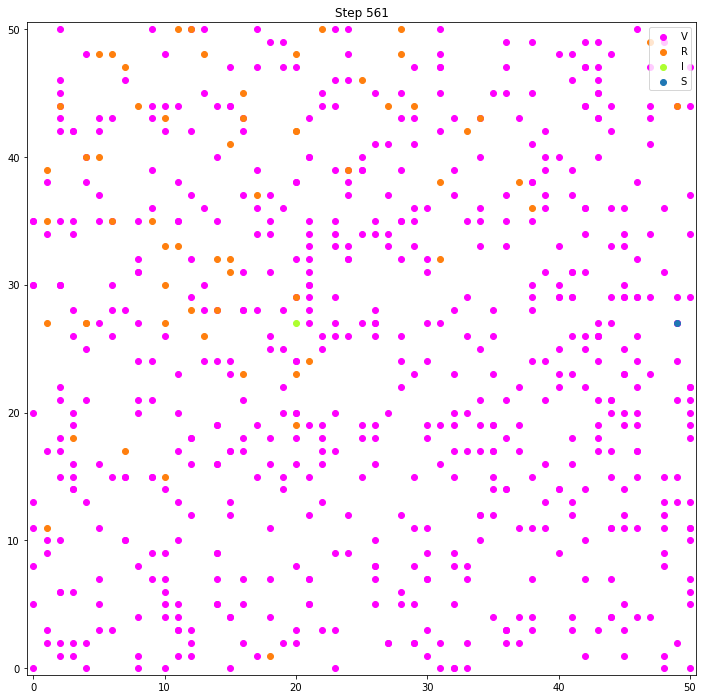

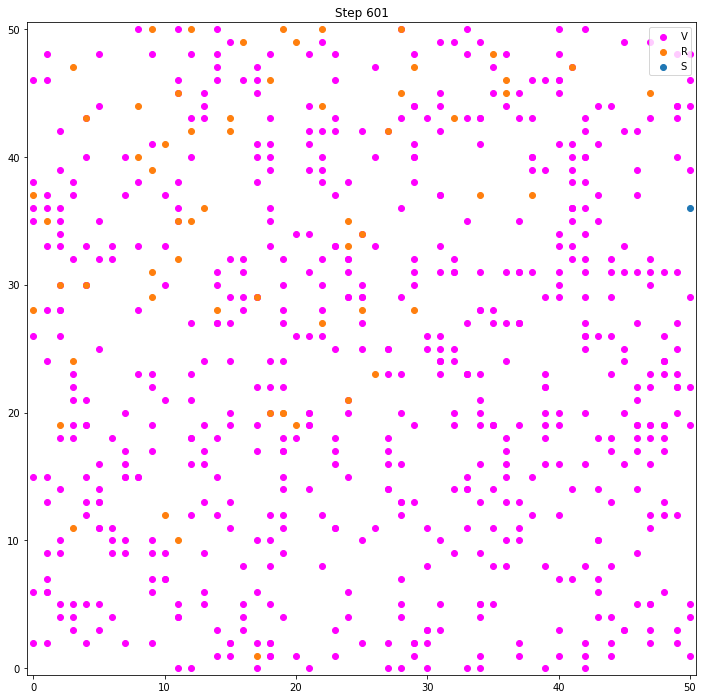

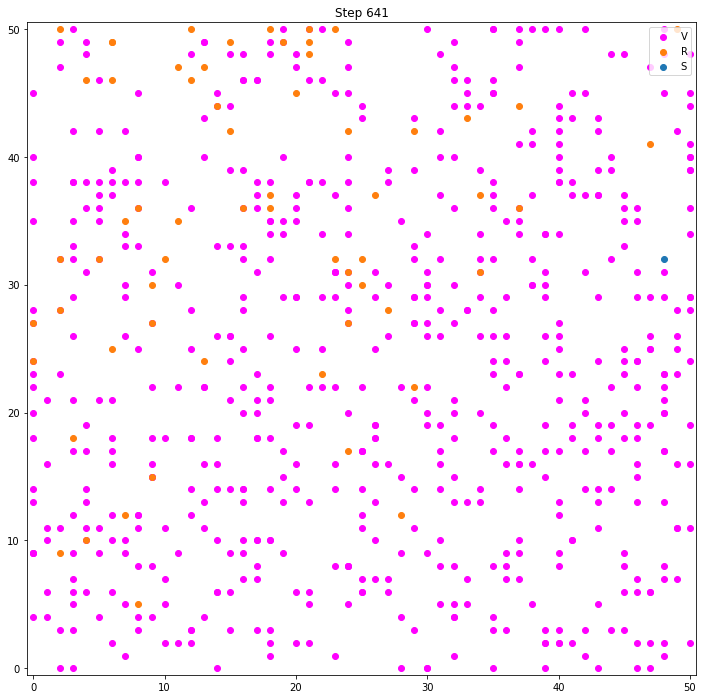

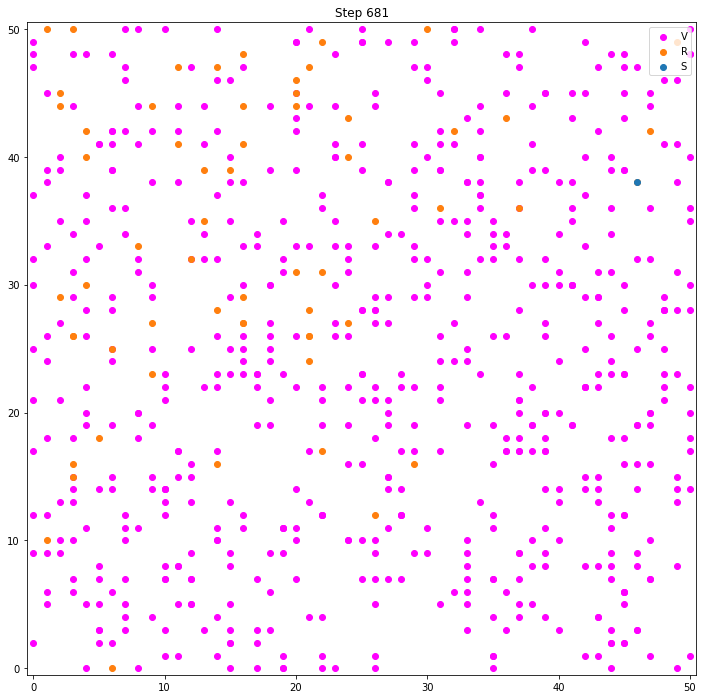

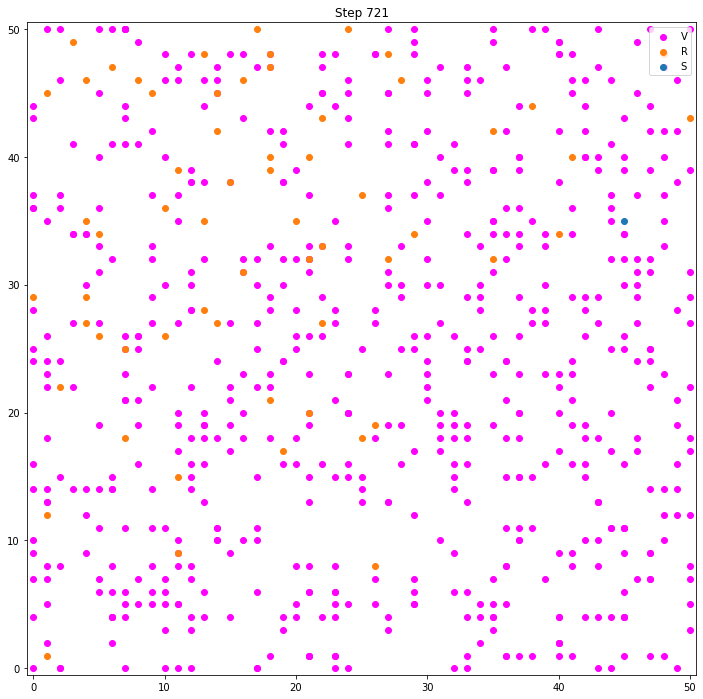

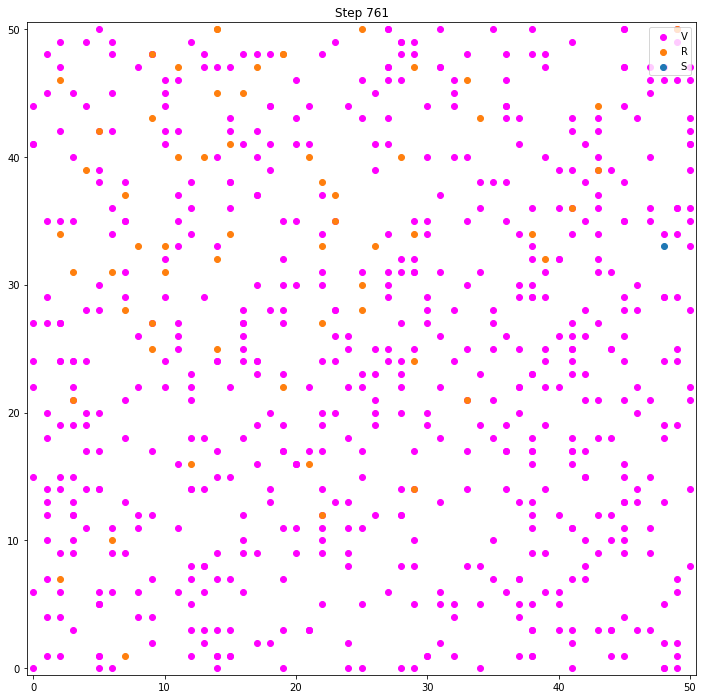

In [55]:
steps = 800
S_Ex4,V_Ex4,I_Ex4,R_Ex4 = COVID_RW_single_simulation_run(no_init_infected=1,population_size=683,nx=50,ny=50,steps=steps,report_every_n_steps=40,precover=0.01,pvaccinate=0.01,crit_pop_percentage=0,report_infos=False)

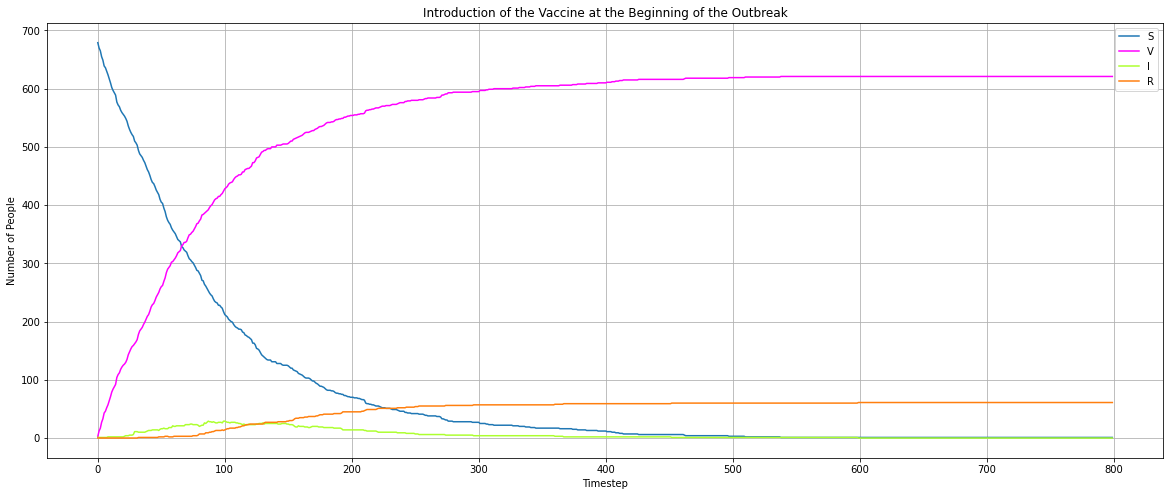

In [56]:
plt.figure(figsize=[20,8])
plt.plot(np.arange(0,steps,1),S_Ex4,label='S',c='tab:blue')
plt.plot(np.arange(0,steps,1),V_Ex4,label='V',c='magenta')
plt.plot(np.arange(0,steps,1),I_Ex4,label='I',c='greenyellow')
plt.plot(np.arange(0,steps,1),R_Ex4,label='R',c='tab:orange')
plt.title('Introduction of the Vaccine at the Beginning of the Outbreak')
plt.xlabel('Timestep')
plt.ylabel('Number of People')
plt.grid()
plt.legend()

The plot above shows that introducing the vaccine right at the beginning of the outbreak reduces the number of susceptible people and therefore the number of people getting infected by the disease substantially.

Note that the vaccine gets introduced right with the beginning of the outbreak of the disease. This is not realistic as a certain percentage of the population has to be infected first for a disease and the need for a vaccine to be recognized by the population. Also samples from infected people are needed to develop the vaccine. Developing, testing and approving a vaccine takes time aswell.

### Introducing the Vaccine after a percentage of the population got infected

For a more realistic representation the vaccine is introduced after 20% of the population got infected by the disease in the simulation below.

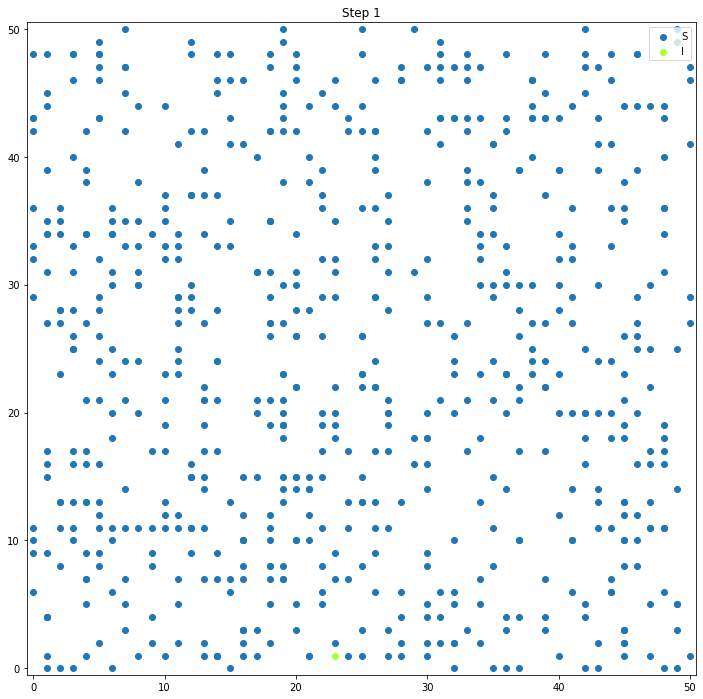

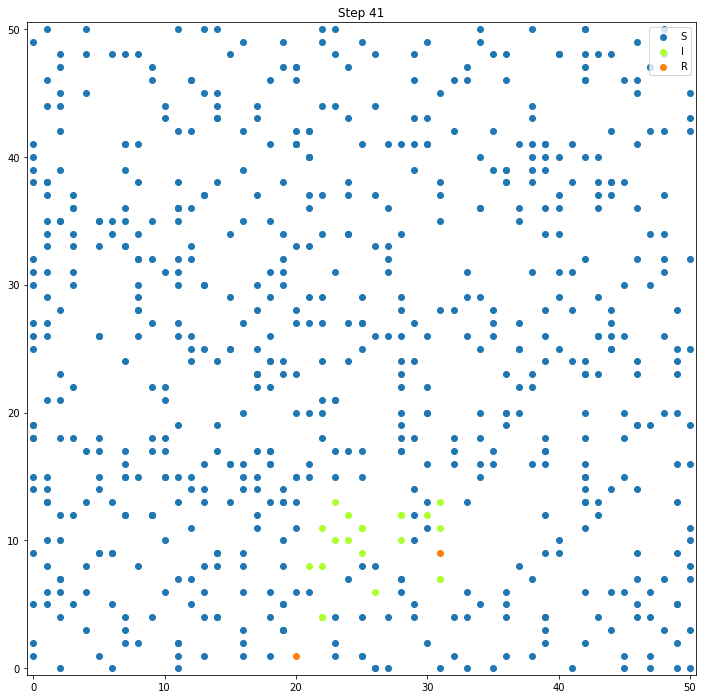

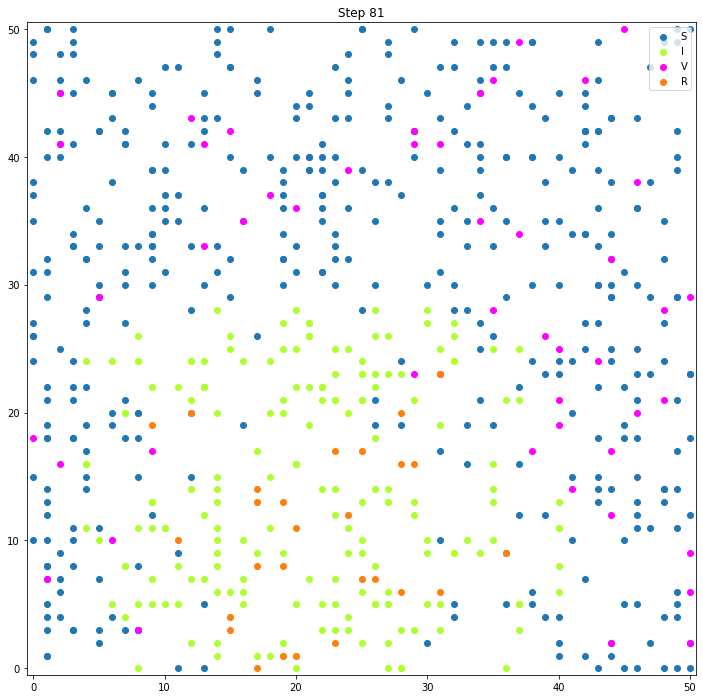

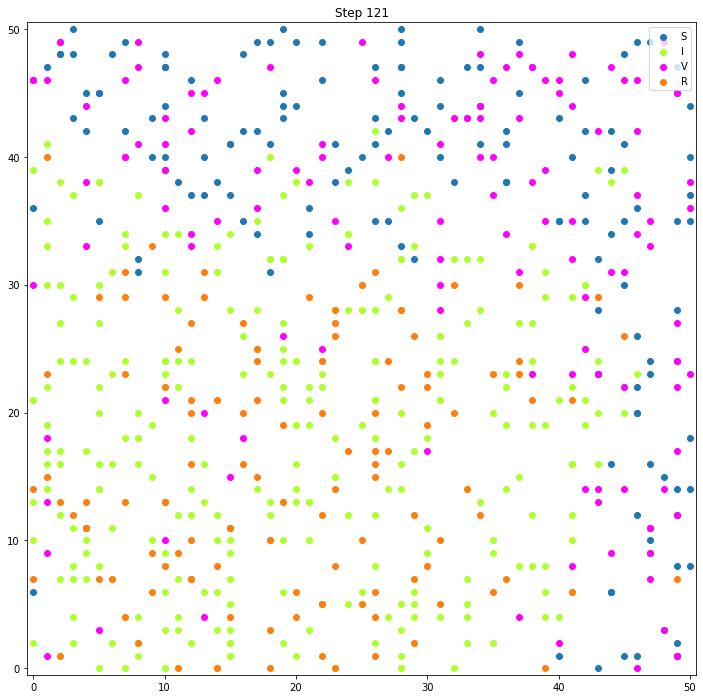

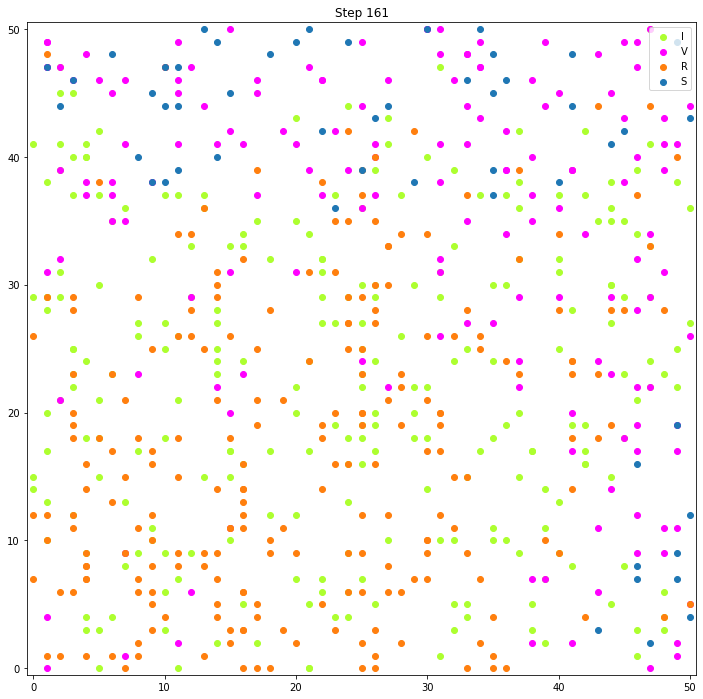

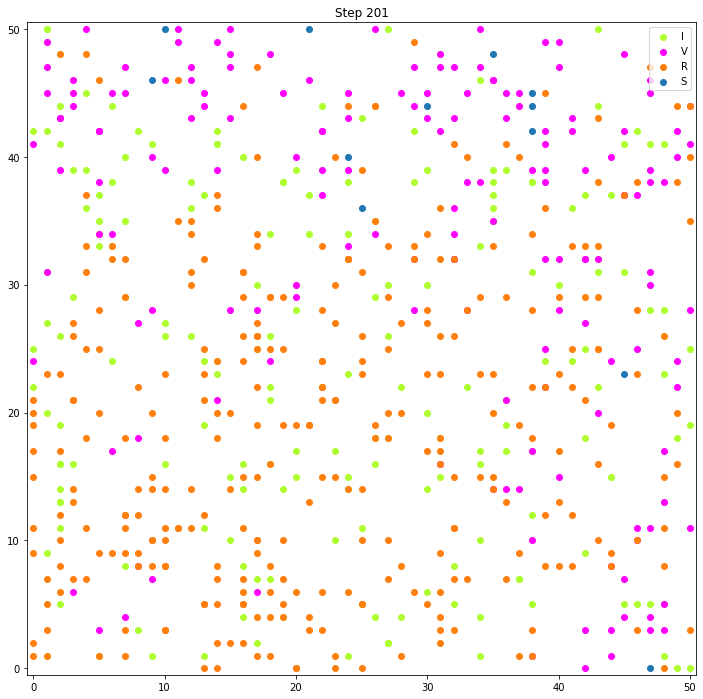

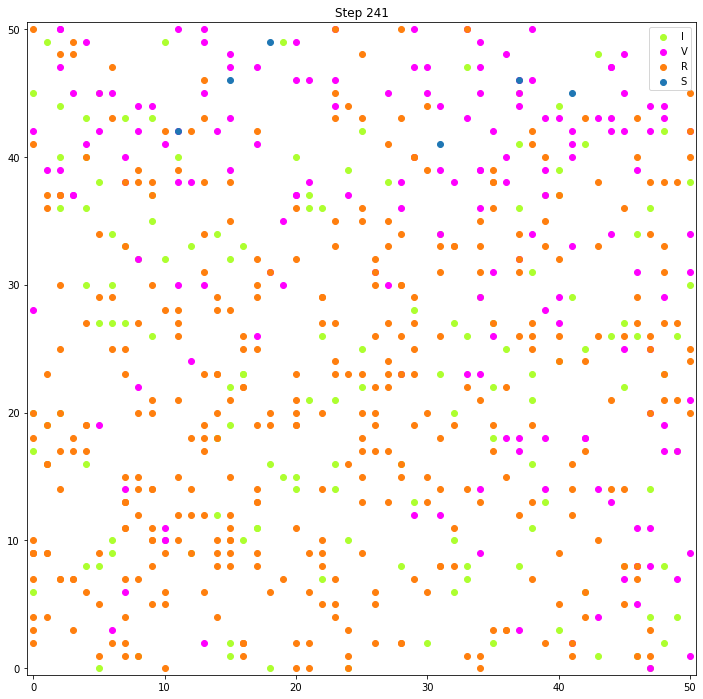

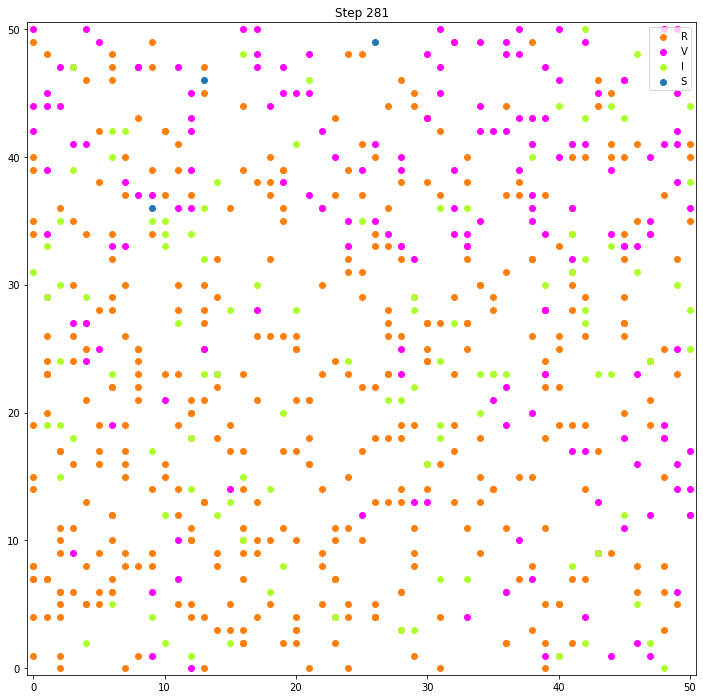

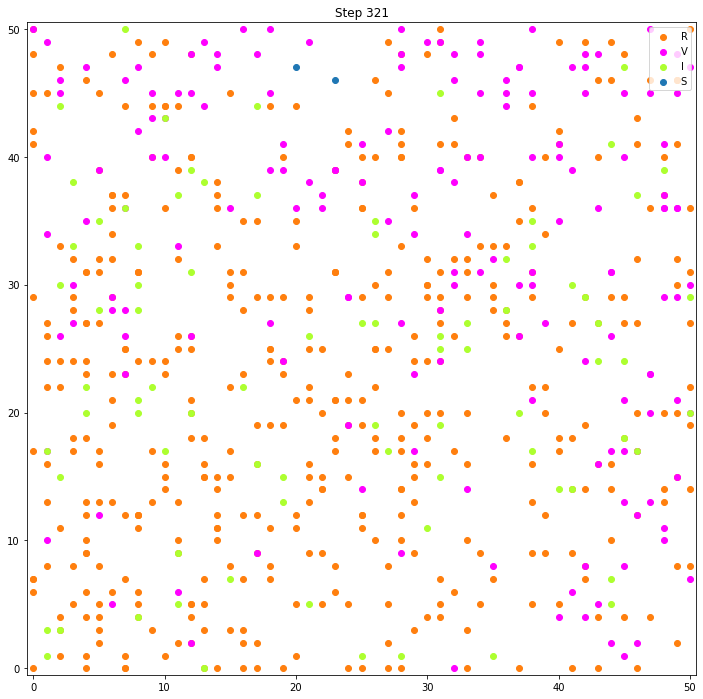

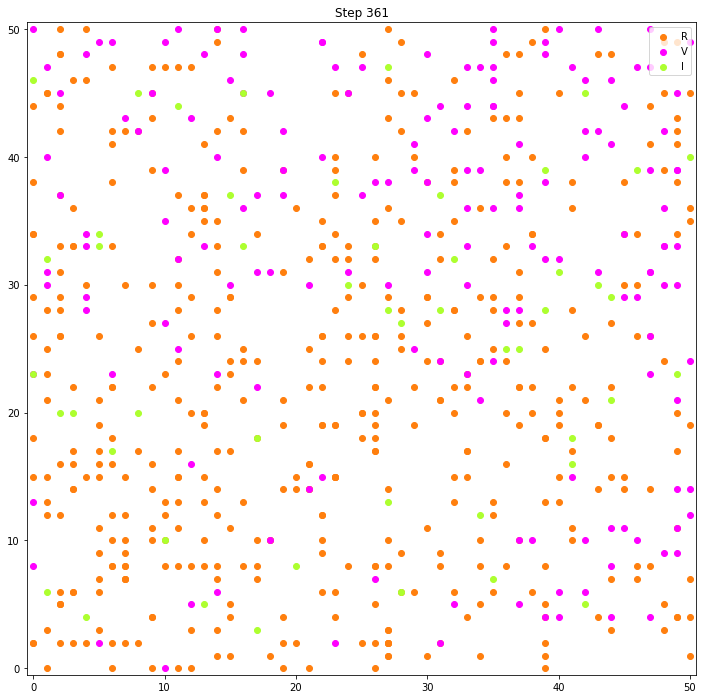

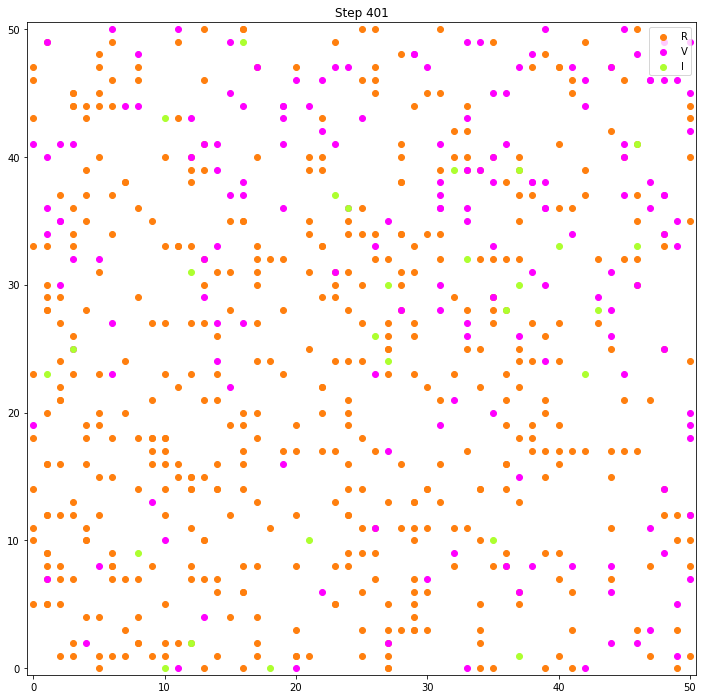

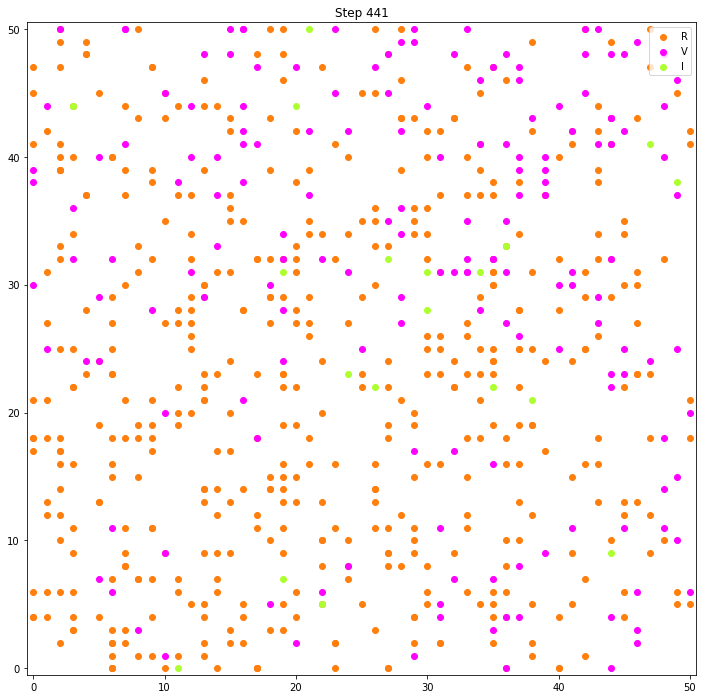

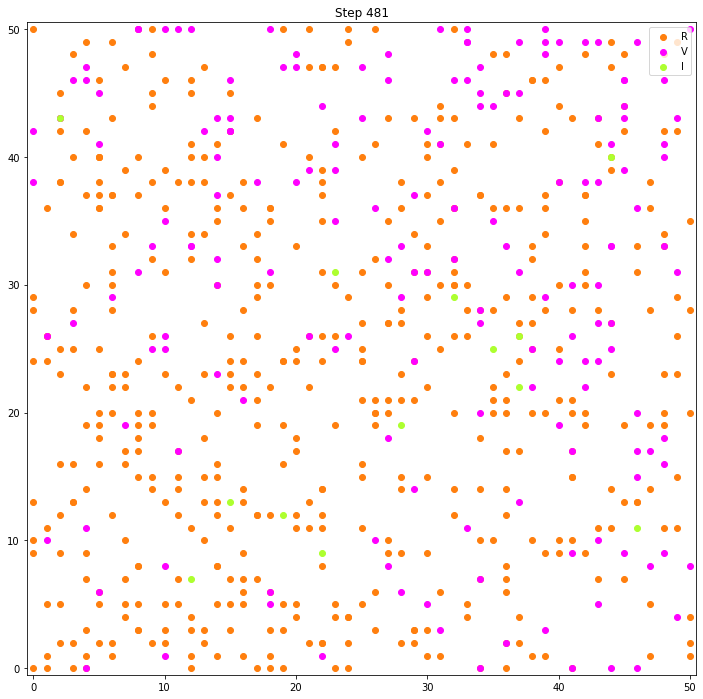

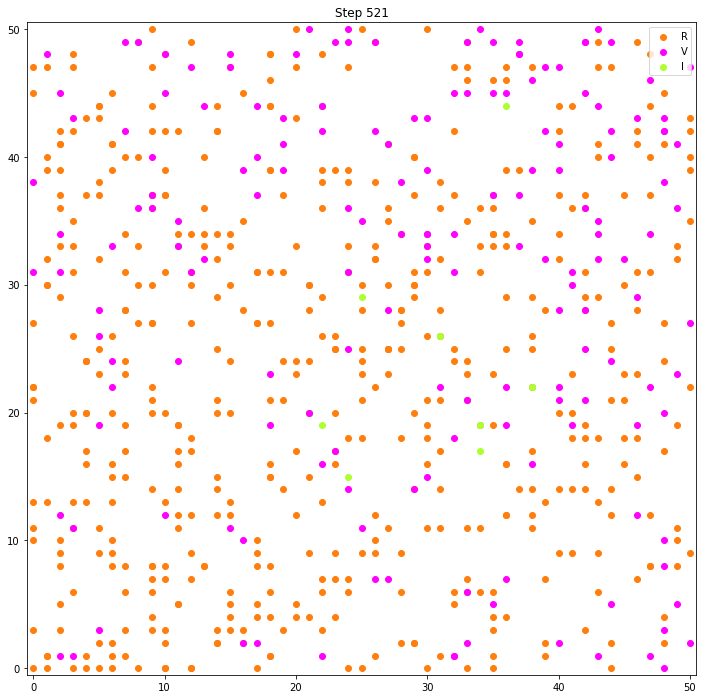

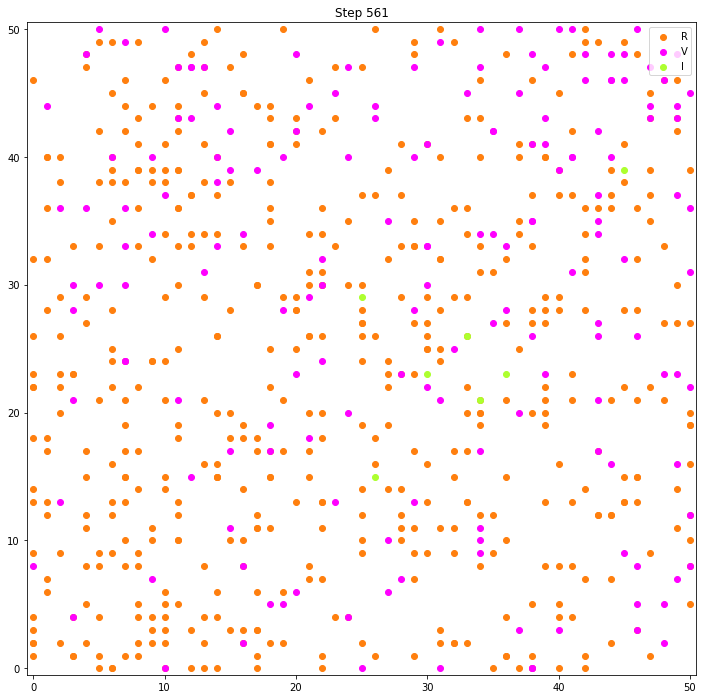

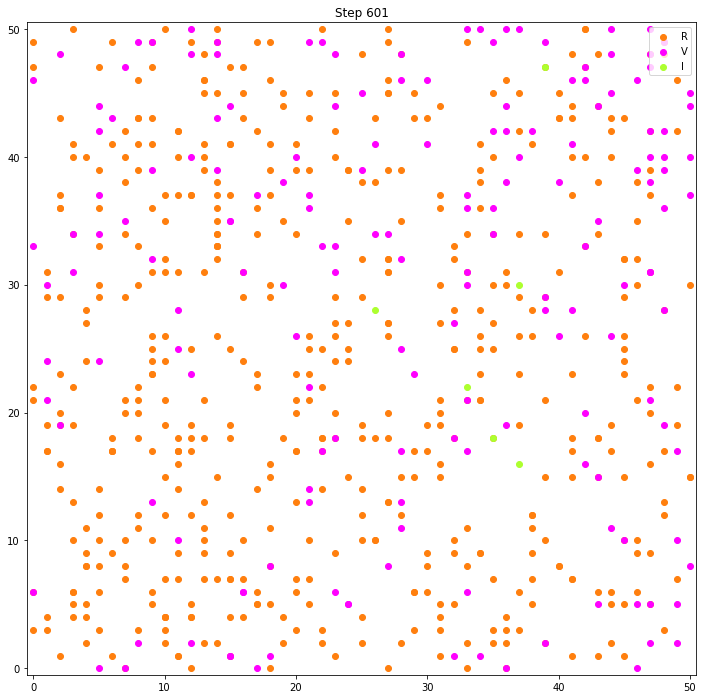

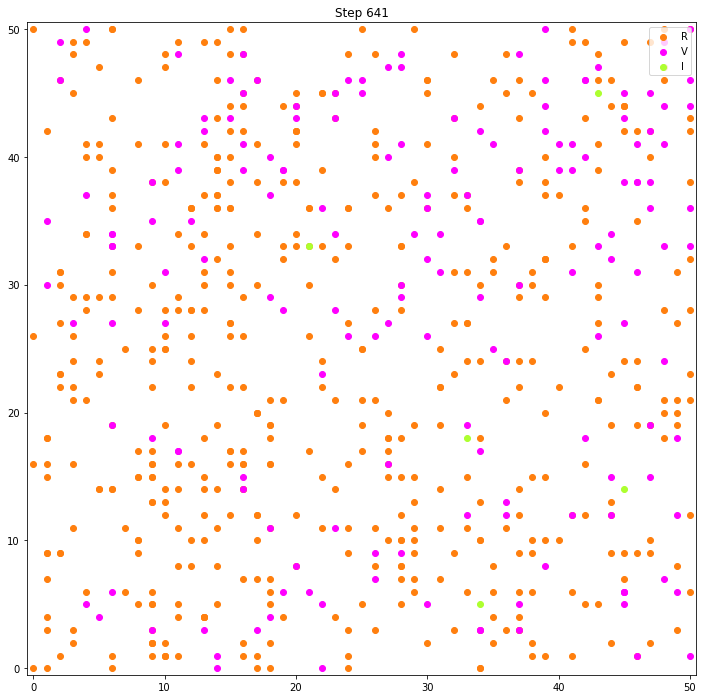

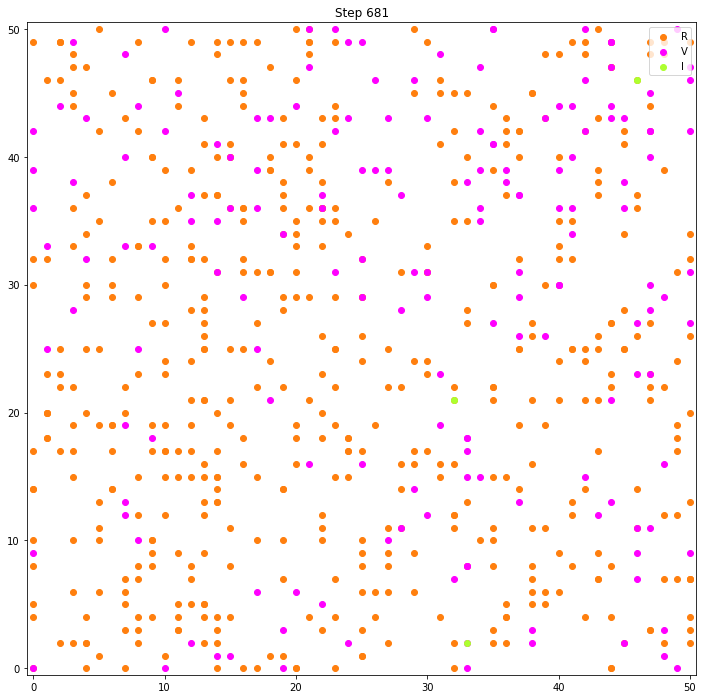

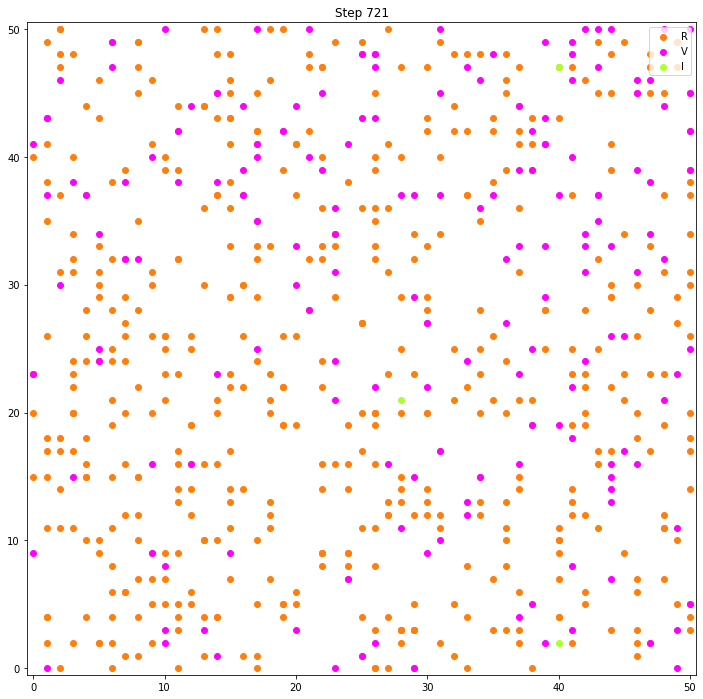

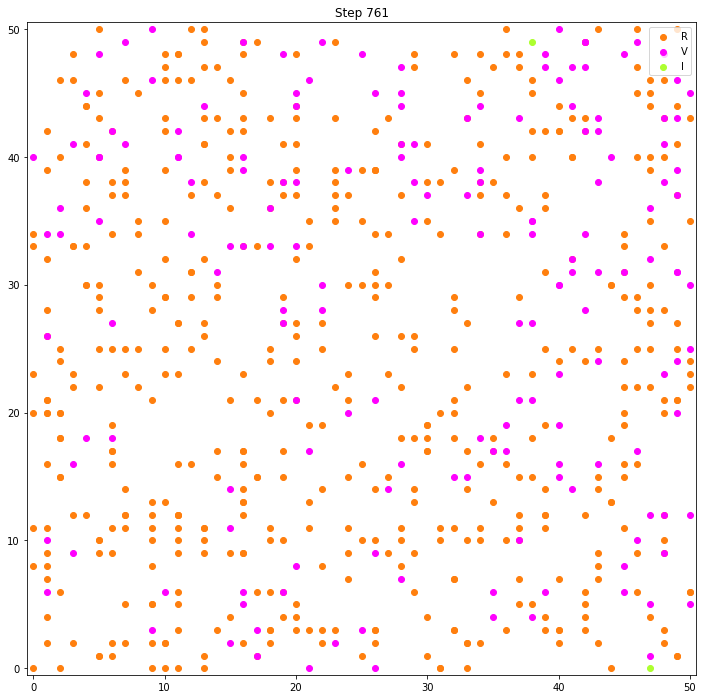

In [57]:
steps_2 = 800
S_Ex4_2,V_Ex4_2,I_Ex4_2,R_Ex4_2 = COVID_RW_single_simulation_run(no_init_infected=1,population_size=683,nx=50,ny=50,steps=steps_2,report_every_n_steps=40,precover=0.01,pvaccinate=0.01,crit_pop_percentage=20,report_infos=False)

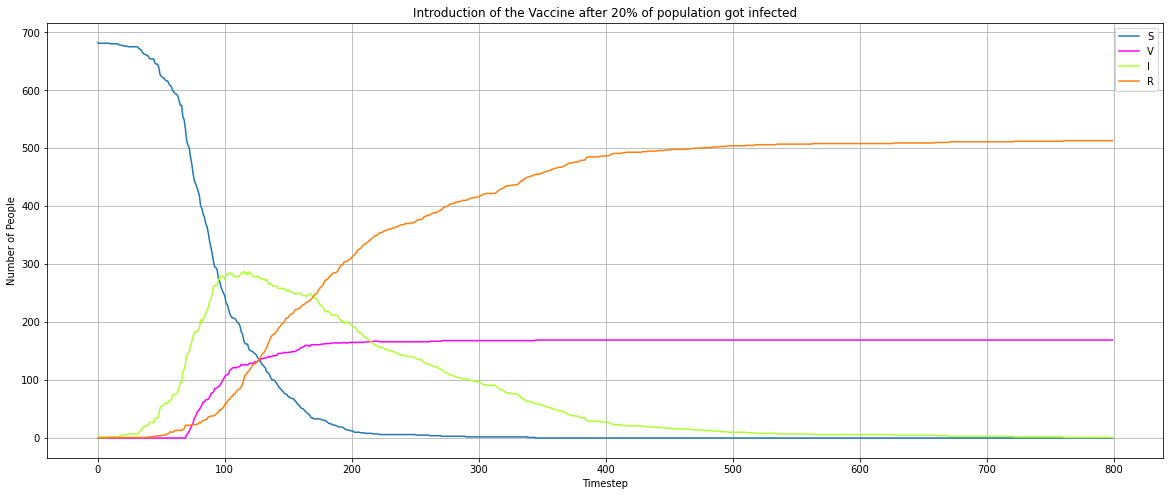

In [58]:
plt.figure(figsize=[20,8])
plt.plot(np.arange(0,steps_2,1),S_Ex4_2,label='S',c='tab:blue')
plt.plot(np.arange(0,steps_2,1),V_Ex4_2,label='V',c='magenta')
plt.plot(np.arange(0,steps_2,1),I_Ex4_2,label='I',c='greenyellow')
plt.plot(np.arange(0,steps_2,1),R_Ex4_2,label='R',c='tab:orange')
plt.title('Introduction of the Vaccine after 20% of population got infected')
plt.xlabel('Timestep')
plt.ylabel('Number of People')
plt.grid()
plt.legend()
plt.show()

The plot above shows that with a later introduction of the vaccine, more people will get infected and eventually recover (or die). The number of infected people is still lower than without the vaccine though.

### Increasing the vaccination rate

To increase the effectiveness of the (later introduced) vaccine again a better vaccination campaign is implemented by increasing the vaccination rate in the simulation below.

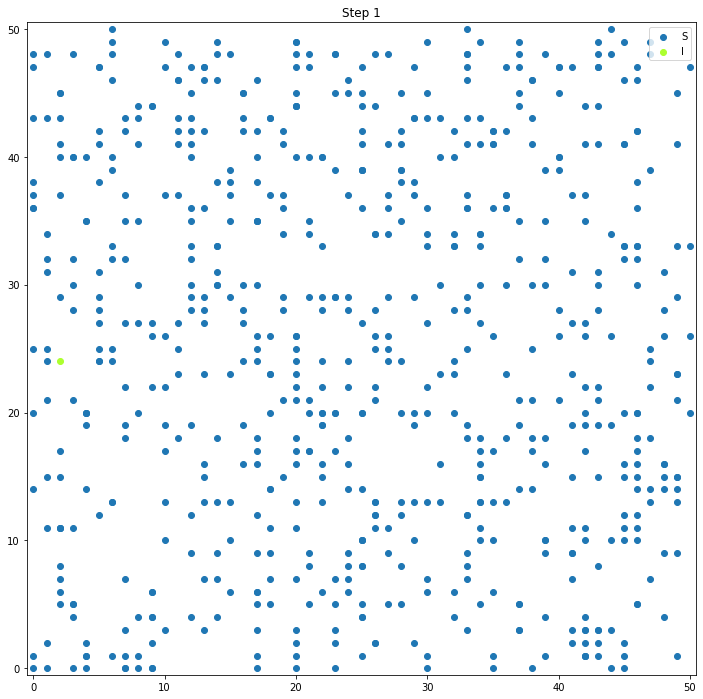

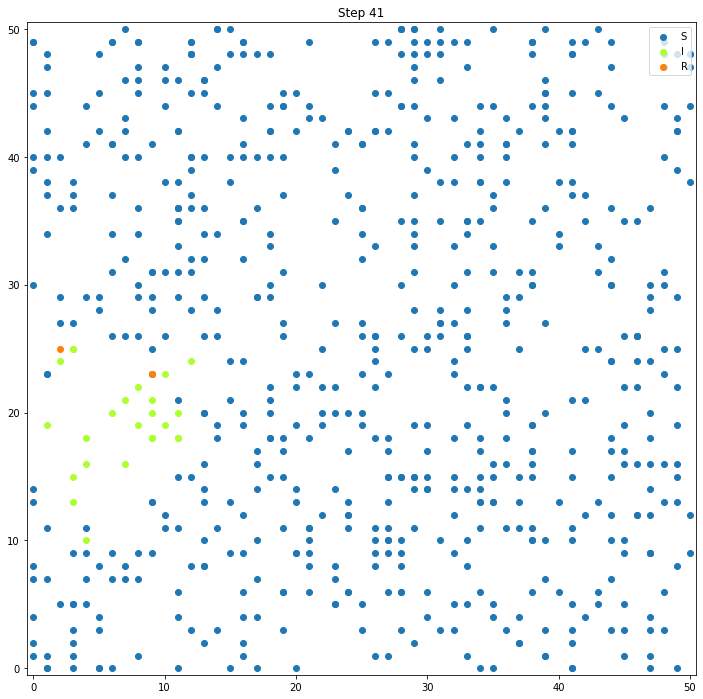

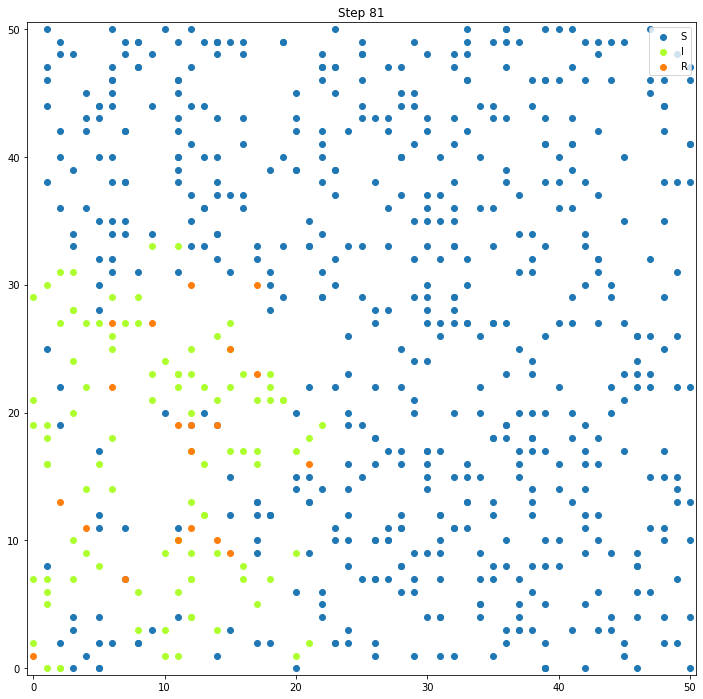

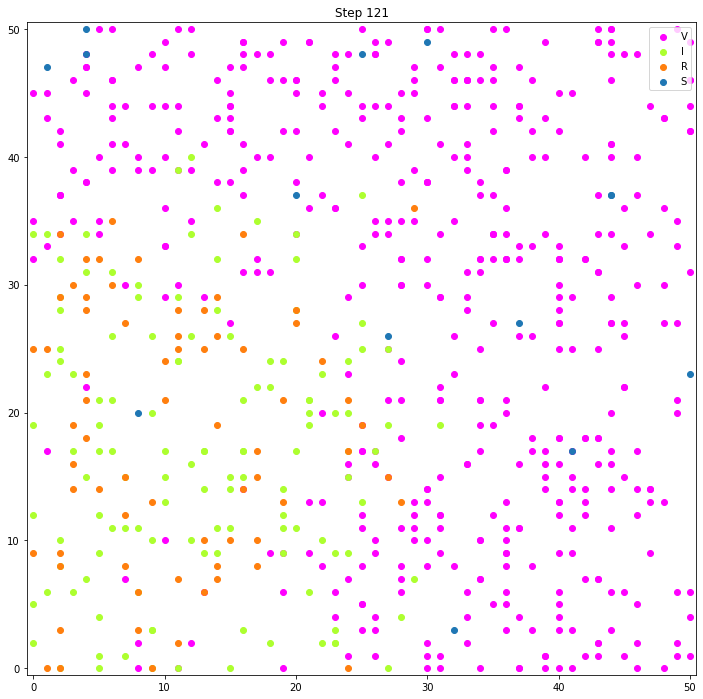

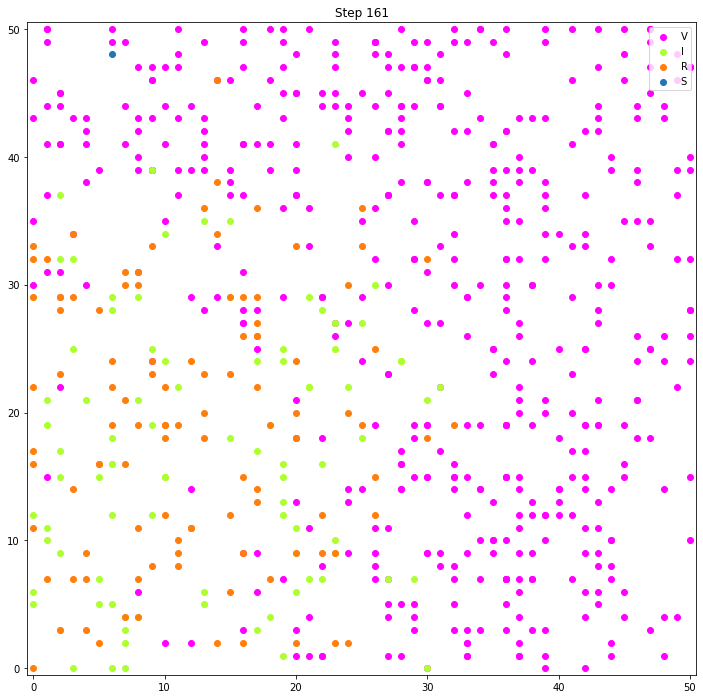

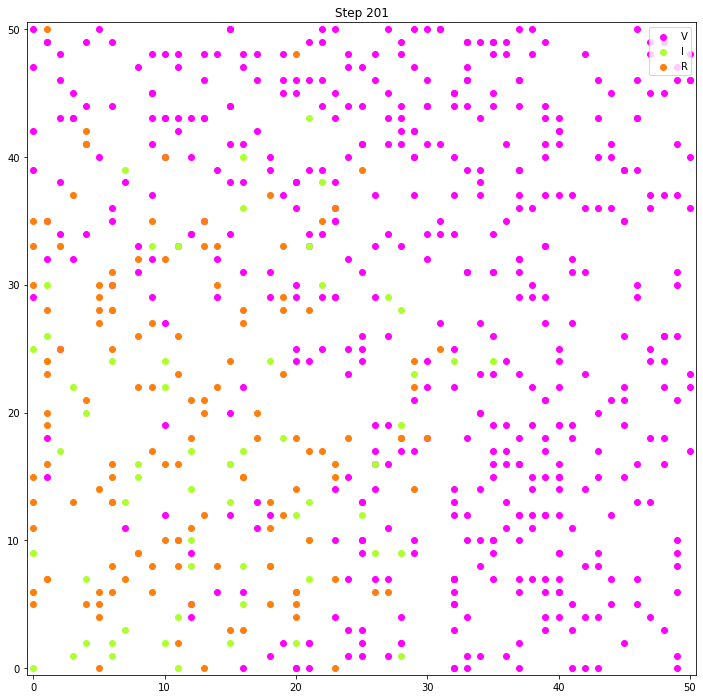

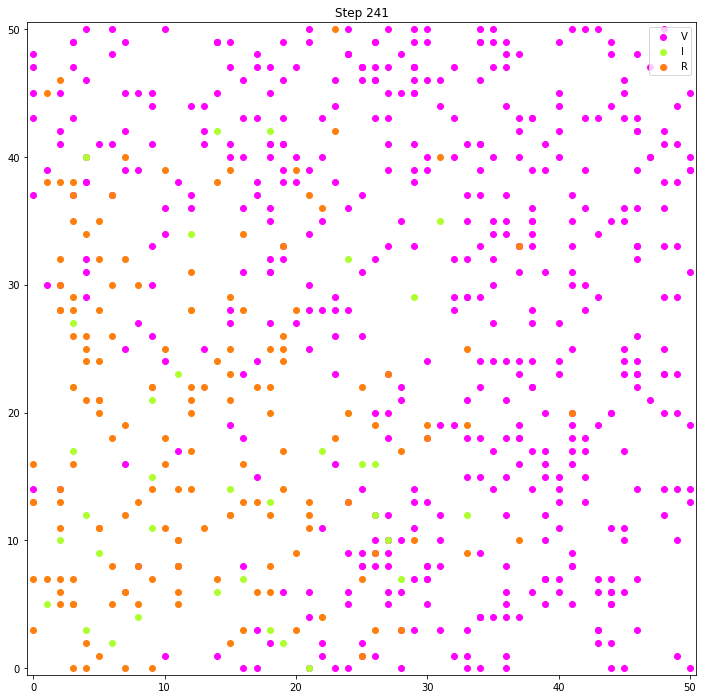

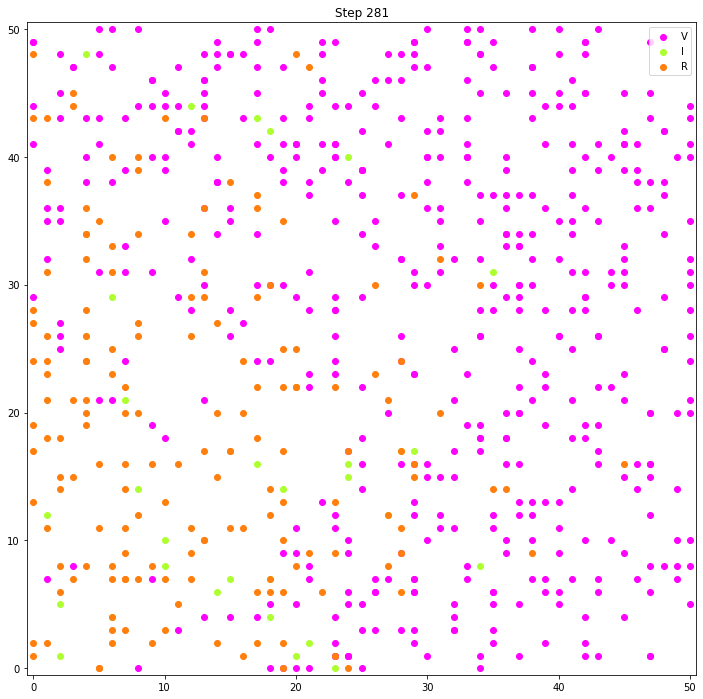

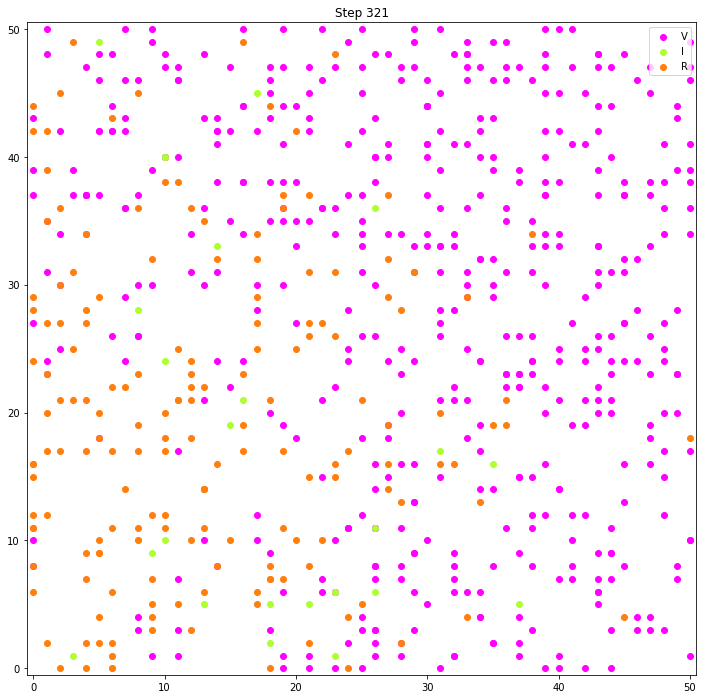

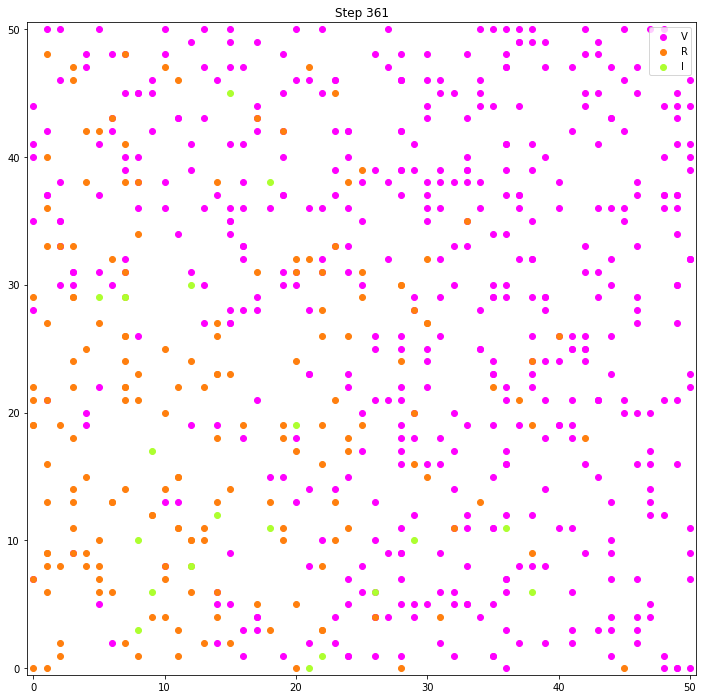

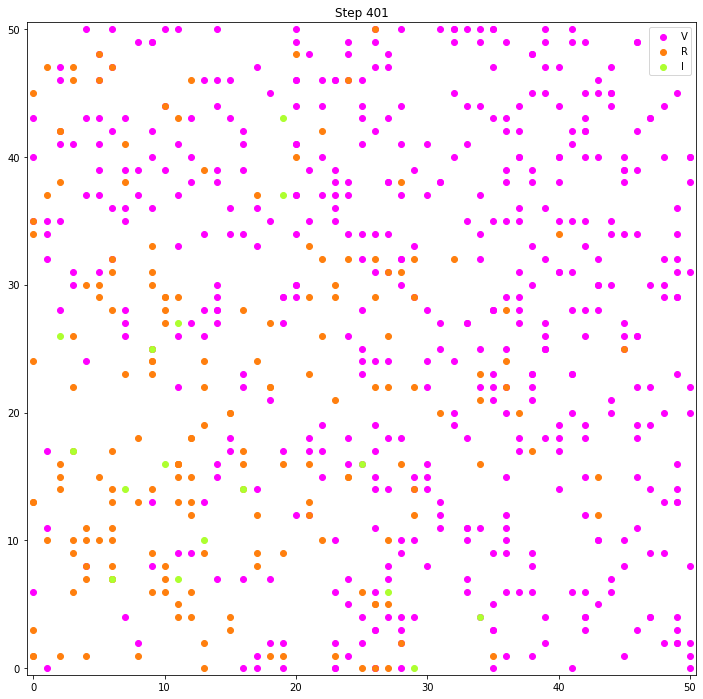

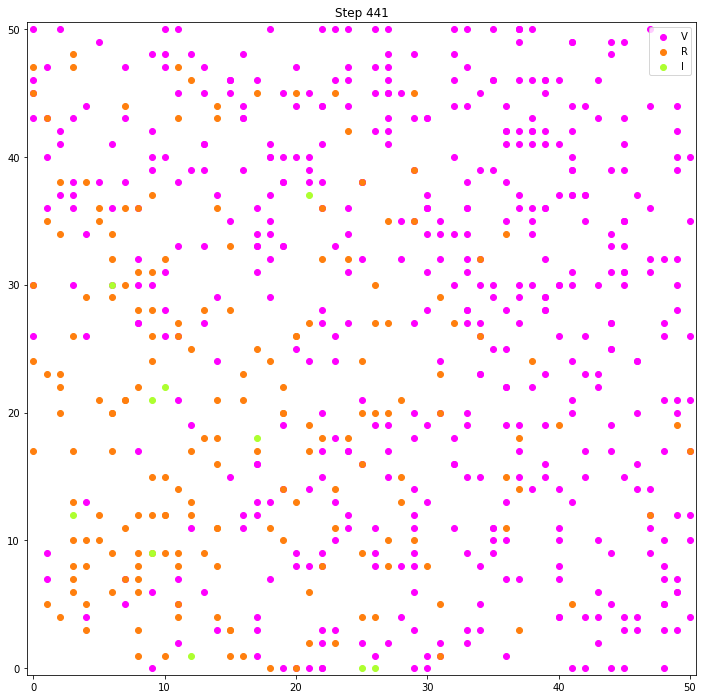

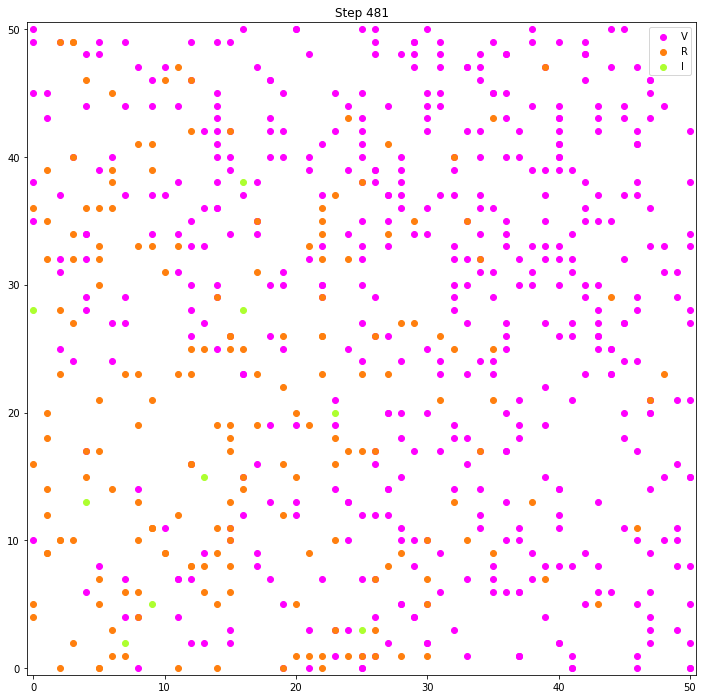

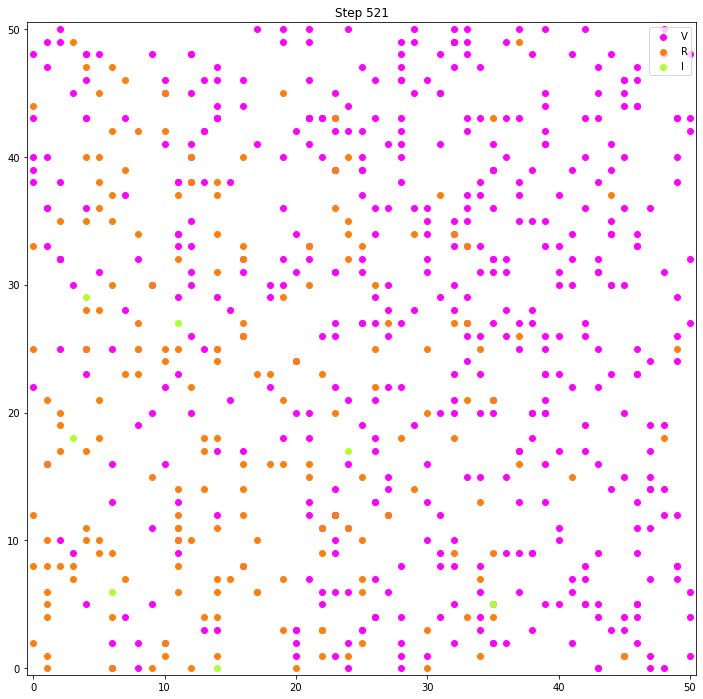

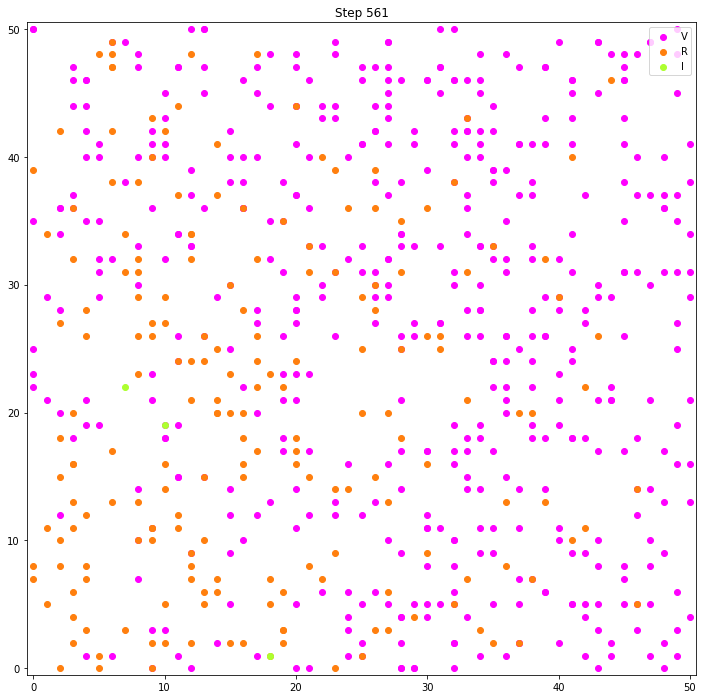

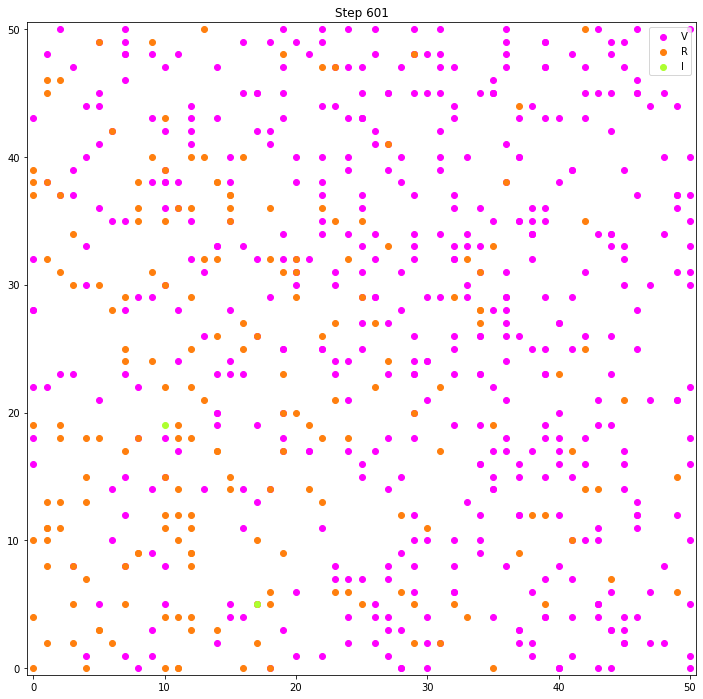

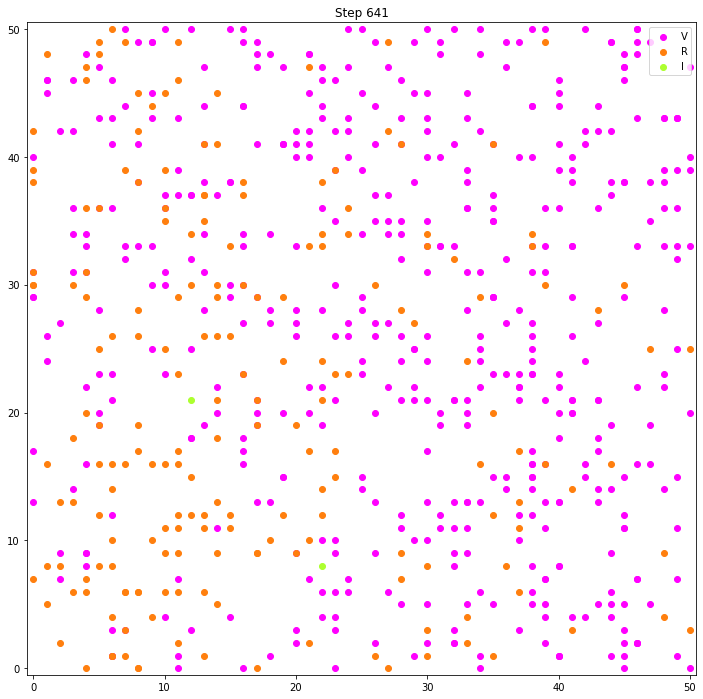

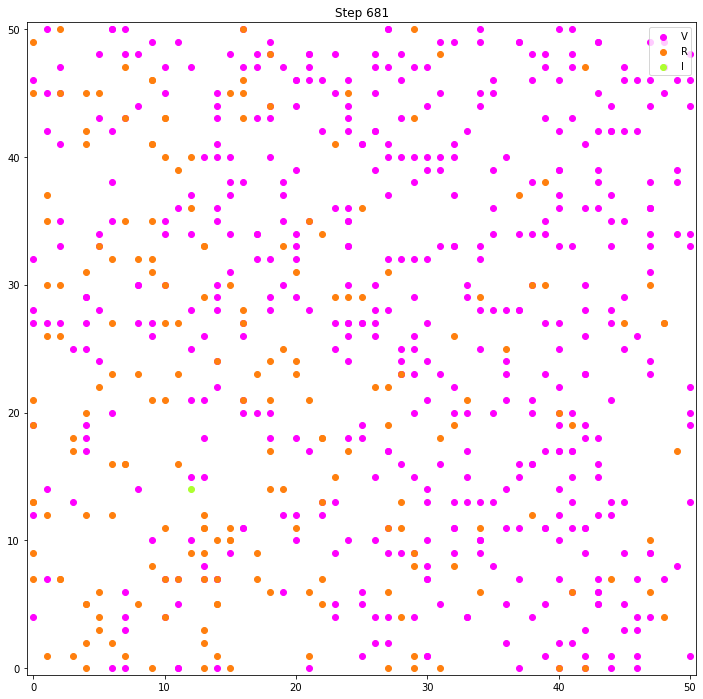

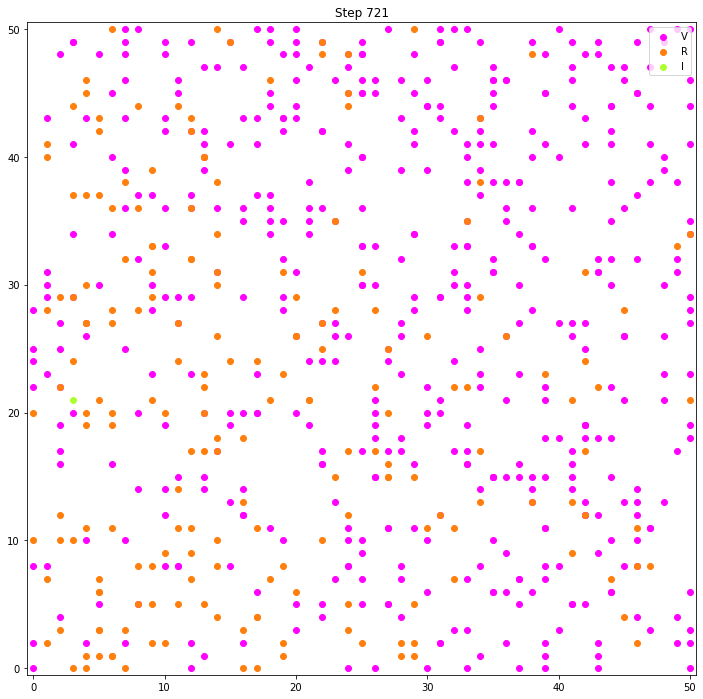

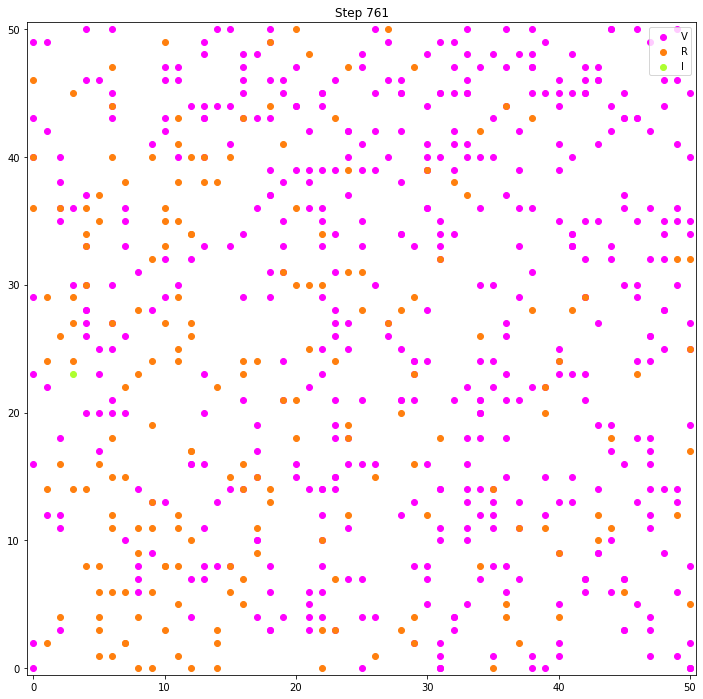

In [59]:
steps_3 = 800
S_Ex4_3,V_Ex4_3,I_Ex4_3,R_Ex4_3 = COVID_RW_single_simulation_run(no_init_infected=1,population_size=683,nx=50,ny=50,steps=steps_3,report_every_n_steps=40,precover=0.01,pvaccinate=0.1,crit_pop_percentage=20,report_infos=False)

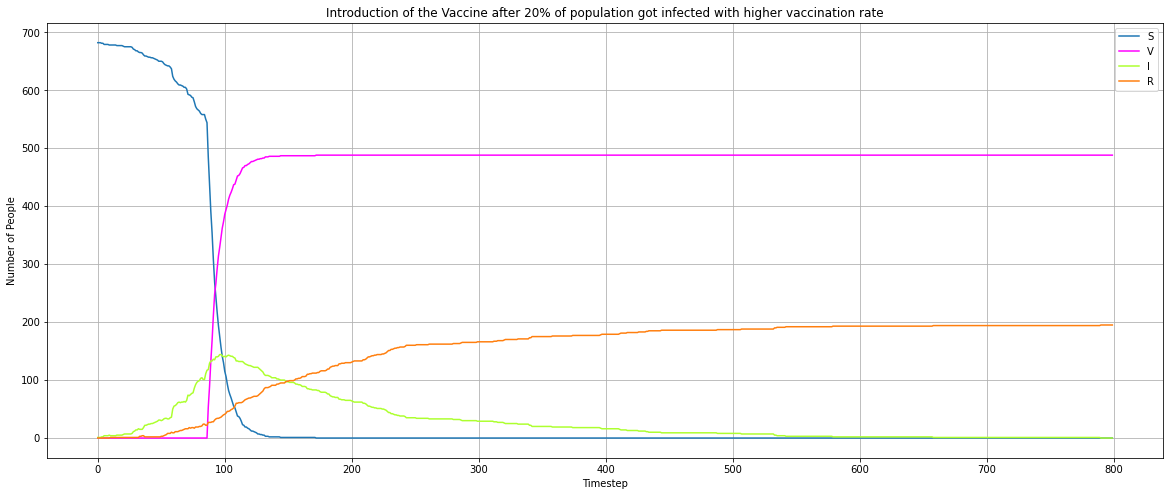

In [60]:
plt.figure(figsize=[20,8])
plt.plot(np.arange(0,steps_3,1),S_Ex4_3,label='S',c='tab:blue')
plt.plot(np.arange(0,steps_3,1),V_Ex4_3,label='V',c='magenta')
plt.plot(np.arange(0,steps_3,1),I_Ex4_3,label='I',c='greenyellow')
plt.plot(np.arange(0,steps_3,1),R_Ex4_3,label='R',c='tab:orange')
plt.title('Introduction of the Vaccine after 20% of population got infected with higher vaccination rate')
plt.xlabel('Timestep')
plt.ylabel('Number of People')
plt.grid()
plt.legend()
plt.show()

The plot above shows that increasing the vaccination rate reduces the number of people getting infected and eventually recovering (or dying) aswell as reducing the time the infection stays in the populaiton.

## Conclusion

Random walk algorithms in conjunction with compartment models give a good insight in the mechanisms of an infectious disease outbreak and spread in a population through the use of scatterplots, looking at the development of the outbreak in lineplots and deriving parameters to compare the results with analytical solutions and deterministic compartment models. 

Since alot of randomness is introduced in random walk algorithms and a single run could even (albeit very rarely) be an edgecase, where the only infected walker does not meet another walker before recovering and therefore no one gets infected. Therefore mean and standard deviation have to be calculated over multiple runs to be able to plot smooth lines for the mean values and display the corresponding uncertainty.

This makes random walk algorithms computationally more demanding than other methods. 

On the other hand random walk algorithms are easily extended and adjusted to allow for more compartments, such as recovered and vaccinated people, and more precisely define simulation parameters, such as population densitiy (through adjusting population and gird size), infection rate, recovery rate, vaccination rate and vaccine introduction conditions.

Examining the effect of changing these parameters provides insight in the mechanisms of the spread and outbreak of infectious diseases such as covid19. 

The base reproductive number R0, comprised of beta and tau_sick, which can be derivated from the random walk models, is dependant on the population size and density (through grid size), the number of initially infected people, the infection rate and the recovery rate parameters. The more people an infected person meets, the higher the infection probability and the longer the time infected, the higher will be the number of secondary infections and therefore the reproductive number R0.

Introducing vaccines fast (with high vaccination rate) and as early as possible reduces the number of infected and therefore the number of recovered (or dead) people in a population.

Further planned extensions to be examined, that could not be implemented due to time constraints, include:
- Expending the SVIR-model to the SVIRD-model, including dead people with a given mortality rate
- Introducing inner walls to simulate the closing of boarders after a certain percentage of the population got infected
- Introducing teleportation points at certain coordinates in the above created compartments to simulate airports



## Selfreflection

 - Learned more about:
    - Using random walk simulations in conjunction with compartment models to simulate the spread of infectious diseases
    - Modifying and extending random walk simulations to add features and parameters to a simulation
    - The details of the mechanisms involved in the spread and outbreak of infectious diseases
    - How to use simulations to find effective counter measures to an outbreak of an infectious disease (rapid vaccination)

 - Faced difficulties while:
    - Trying to understand and utilize multiprocessing

## References ##

- [1] World Health Organization. WHO Coronavirus (COVID-19) Dashboard, 2021. https://covid19.who.int/, 12/12/2021
- [2] Institute for Health Metrics and Evaluation. COVID-19 Projections. University of Washington, 2021. https://covid19.healthdata.org/global?view=cumulative-deaths&tab=trend, 12/12/2021
- [3] Nicholas LePan and Harrison Schell. Visualizing the History of Pandemics. Visual Capitalist, 2020 https://www.visualcapitalist.com/history-of-pandemics-deadliest/, 12/12/2021
- [4] UNAIDS. Global HIV & AIDS statistics — Fact sheet, 2021 https://www.unaids.org/en/resources/fact-sheet, 12/12/2021